In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from matplotlib.ticker import MaxNLocator, FuncFormatter

In [2]:
sns.__version__

'0.11.2'

In [3]:
sns.set(rc={'figure.figsize':(14, 7)})
sns.set_style("whitegrid")

In [4]:
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [5]:
def read_dataset(filename):
    df = pd.read_csv(filename)
    df["time"] += 1
    df["num_kmers"] += 1
    df["k"] = df["k"].astype(int)
    df["avg"] = df["time"] / df["num_kmers"]
    return df

In [6]:
def plot(df, omega, title, alpha=0.5, stylek=False):
    fig, axs = plt.subplots(ncols=2)
    fig.set_size_inches(18, 8)
    
    dfx = df[df["omega"] == omega]
    if stylek:
        g1 = sns.scatterplot(x="num_kmers", y="time", hue="alg", style="k", data=dfx, ax=axs[0], alpha=0.5)
        g2 = sns.scatterplot(x="num_kmers", y="time", hue="alg", style="k", data=dfx, ax=axs[1], alpha=0.5)
    else:
        g1 = sns.scatterplot(x="num_kmers", y="time", hue="alg", data=dfx, ax=axs[0], alpha=alpha)
        g2 = sns.scatterplot(x="num_kmers", y="time", hue="alg", data=dfx, ax=axs[1], alpha=alpha)
    g2.set_yscale("log")
    g2.set_xscale("log")
    
    
    fig.suptitle(title)
    xlabel = "Num of k-mers"
    ylabel = "Time to process a window, microseconds"
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylabel(ylabel)
    axs[1].set_xlabel(xlabel)
    axs[1].set_ylabel(ylabel)
    
    #return fig

In [7]:
def kde(df, omega, title, alpha=0.4):
    #fig.set_size_inches(18, 8)
    
    dfx = df[df["omega"] == omega]
    sns.displot(x="num_kmers", y="time", hue="alg", data=dfx, alpha=alpha)
    
    plt.title(title)
    xlabel = "# of phylo-k-mers generated"
    ylabel = "Time to process a window, microseconds"
    plt.xticks(rotation=30)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    


In [176]:
#palette = sns.color_palette("Set2", 6)
#palette

# GeoDataViz color palette
# https://github.com/OrdnanceSurvey/GeoDataViz-Toolkit/blob/master/Colours/GDV-colour-palettes-v0.7.json
palette = ["#ff1f5b",
"#00cd6c",
"#009ade",
"#af58ba",
"#ffc61e",
"#f28522",
"#a0b1ba",
"#a6761d"]

In [9]:
# Average time per window of size Zbase (+- delta%) for different k
def plot1(df, Zbase, delta, ax, **kwargs):
    title = kwargs.get("title", "")
    legend = kwargs.get("legend", False)
    ylabel = kwargs.get("ylabel", False)
    
    Delta = Zbase / 100 * delta
    dfb = df[df["num_kmers"].between(Zbase - Delta, Zbase + Delta)]
    
    g = sns.lineplot(data=dfb, x="k", y="time", hue="alg", marker='o', palette=palette, ax=ax, legend=legend)
    #sns.despine(offset=10, trim=True);
    #g.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    g.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    g.set_yscale("log")
    ytext = "Mean running time per window, microsec" if ylabel else ""
    g.set_ylabel(ytext)
    g.set_title(title)
    
    #plt.legend(title='Algorithm', loc='upper left')
    if legend:
        leg = g.axes.get_legend()
        leg.set_title("Algorithm")
        tx = leg.texts
        for t in tx:
           t.set_text(t.get_text().upper())
    
    return g
    

In [10]:
def plot1_collection(df, **kwargs):
    z_values = kwargs.get("z_values", [10, 100, 1000, 10000])
    num_plots = len(z_values)

    sns.set(rc = {'figure.figsize':(5 * num_plots, 5)})
    sns.set_style("whitegrid")

    fig, ax = plt.subplots(1, num_plots)

    for i, z in enumerate(z_values):
        ylabel = (i == 0)
        legend = (i == 0)
        g1 = plot1(df, z, 1, ax[i], ylabel=ylabel, legend=legend, title=r"$|\mathcal{Z}|\approx$" + str(z))

    plt.tight_layout()
    #return fig

In [11]:
# Mean time per window with differenet number of alive k-mers (fixed k), a rarefied plot
def plot2(df, k, ax=None, **kwargs):
    sample_size = kwargs.get("sample_size", 5000)
    all_k = kwargs.get("all_k", False)
    title = kwargs.get("title", "")
    legend = kwargs.get("legend", False)
    ylabel = kwargs.get("ylabel", False)
    logy = kwargs.get("logy", False)
    
    dfk = df if all_k else df[df["k"] == k]
    dfg = dfk.groupby(['num_kmers', 'k', 'omega', 'alg']).mean().reset_index()
    
    max_num_kmers = dfk["num_kmers"].max()
    log_max_num_kmers = np.log10(max_num_kmers)
    
    space = np.linspace(1, max_num_kmers, num=sample_size)
    logspace = np.logspace(1, log_max_num_kmers, num=sample_size)
    
    #space = list(sorted(dfk["num_kmers"].unique()))
    
    if logy:
        df_rarefied = dfg[dfg["num_kmers"].isin(logspace)]
    else:
        df_rarefied = dfg[dfg["num_kmers"].isin(space)]

    num_algs = len(df_rarefied["alg"].unique())
    pal = palette[:num_algs]
    if ax:
        g = sns.scatterplot(data=df_rarefied, x='num_kmers', y='time', hue='alg', ax=ax, palette=pal, legend=legend, edgecolor=None)#edgecolor="black")
    else:
        g = sns.scatterplot(data=df_rarefied, x='num_kmers', y='time', hue='alg', palette=pal, legend=legend)
    g.set_xlabel("$|\mathcal{Z}|$")
    
    ytext = "Mean processing time, microsec" if ylabel else ""
    g.set_ylabel(ytext)
    
    if logy:
        g.set_xscale("log")
        g.set_yscale("log")
        
    g.set_title(title)
    
    # remove borders
    sns.despine()
    
    if legend:
        leg = g.axes.get_legend()
        leg.set_title("Algorithm")
        tx = leg.texts
        for t in tx:
           t.set_text(t.get_text().upper())
    
    return g


In [12]:
def plot2_collection(df, logy=False, **kwargs):    
    filename = kwargs.get("filename", None)
    sample_size = kwargs.get("sample_size", 5000)

    k_values = kwargs.get("k_values", df["k"].unique())
    num_plots = len(k_values)

    sns.set(rc = {'figure.figsize':(5 * num_plots, 5)})
    sns.set_style("white")

    fig, ax = plt.subplots(1, num_plots)

    for i, k in enumerate(k_values):
        ylabel = (i == 0)
        legend = (i == 0)
        g1 = plot2(df, k, ax[i], ylabel=ylabel, legend=legend, title="$k=$" + str(k), sample_size=sample_size, logy=logy)

    plt.tight_layout()
    
    if filename:
        plt.savefig(filename)


In [13]:
# Total time needed to preprocess a dataset for different values of k (fixed omega)
def plot_total_time(df):
    sns.set(rc={'figure.figsize':(7, 5)})
    sns.set_style("white")

    df_sum = df.groupby(["k", "alg"]).sum().reset_index()
    
    pal = palette[:len(df_sum["alg"].unique())]
    g = sns.lineplot(data=df_sum, x="k", y="time", hue="alg", palette=pal, marker='o')

    g.set_ylabel("Total time for the dataset, microsec")
    g.set_yscale("log")
    leg = g.axes.get_legend()
    leg.set_title("Algorithm")
    tx = leg.texts
    for t in tx:
       t.set_text(t.get_text().upper())

# Neotrop

Measurements made for random ghost nodes of Neotrop. All windows of the alignment are considered for every node. Time measurements: microseconds per window

In [14]:
#neotrop = pd.read_csv("results/neotrop-100.csv")
#neotrop = pd.read_csv("results/neotrop-100-o1.5.csv")
#neotrop = read_dataset("results/neotrop-dccw.csv")
neotrop = read_dataset("results-ghost/neotrop.csv")

In [16]:
neotrop

alg  num_kmers  time   k  omega      node  position       avg
0           bb         17    21   6    1.5  Node2356         0  1.235294
1           dc         17     9   6    1.5  Node2356         0  0.529412
2         dccw         17     2   6    1.5  Node2356         0  0.117647
3           bb          7     2   6    1.5  Node2356         3  0.285714
4           dc          7     2   6    1.5  Node2356         3  0.285714
...        ...        ...   ...  ..    ...       ...       ...       ...
68807227    dc      14675   169  12    1.5   Node446      2795  0.011516
68807228  dccw      14675   118  12    1.5   Node446      2795  0.008041
68807229    bb      11256   255  12    1.5   Node446      2801  0.022655
68807230    dc      11256   103  12    1.5   Node446      2801  0.009151
68807231  dccw      11256    91  12    1.5   Node446      2801  0.008085

[68807232 rows x 8 columns]

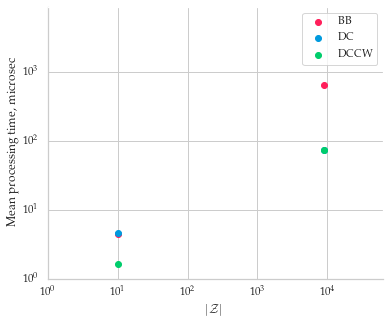

In [15]:
df = neotrop
sample_size = 500
logy = True

colors = {
    'bb': palette[0],
    'dc': palette[2],
    'dccw': palette[1],
    'bbe': palette[5],
    'bl': palette[4],
}
white = "#ffffff"


fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

lines = []
labels = []
for i, alg in enumerate(df.alg.unique()):
    df_alg = neotrop[(df.alg == alg) & (df.k == 10)]
    dfg = df_alg.groupby(['num_kmers', 'k', 'omega', 'alg']).mean().reset_index()
    
    max_num_kmers = dfg["num_kmers"].max()
    log_max_num_kmers = np.log10(max_num_kmers)
    
    #space = np.linspace(1, max_num_kmers, num=sample_size)
    logspace = np.logspace(1, log_max_num_kmers, num=sample_size)
    
    if logy:
        df_rarefied = dfg[dfg["num_kmers"].isin(logspace)]
    else:
        df_rarefied = dfg[dfg["num_kmers"].isin(space)]
        
    color = colors[alg]
    line = ax.scatter(df_rarefied.num_kmers, df_rarefied.time, color=color)
    lines.append(line)
    labels.append(alg)


#box = ax.get_position()

label_map = {
    'bb': 'BB',
    'dc': 'DC',
    'dccw': 'DCCW',
}

for l in labels:
    if l in label_map:
        labels[labels.index(l)] = label_map[l]


ax.legend(lines, labels)

plt.xlim(df["num_kmers"].min(), df["num_kmers"].max())
plt.ylim(df["time"].min(), df["time"].max())

plt.xlabel("$|\mathcal{Z}|$")

plt.ylabel("Mean processing time, microsec")
plt.yscale("log")
plt.xscale("log")
# plt.yticks([60, 10*60, 60*60, 10*60*60, 24*60*60], ['1 min', '10 mins', '1 hour', '10 hours', '1 day'])
# plt.xticks([10**4, 0.5 * 10**5, 10**5], [10**4, int(0.5 * 10**5), 10**5])
# #plt.ticklabel_format(axis="x", style="sci")
# ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


ax.spines['top'].set_color(white) 
ax.spines['right'].set_color(white)

#fig.tight_layout()
plt.show()

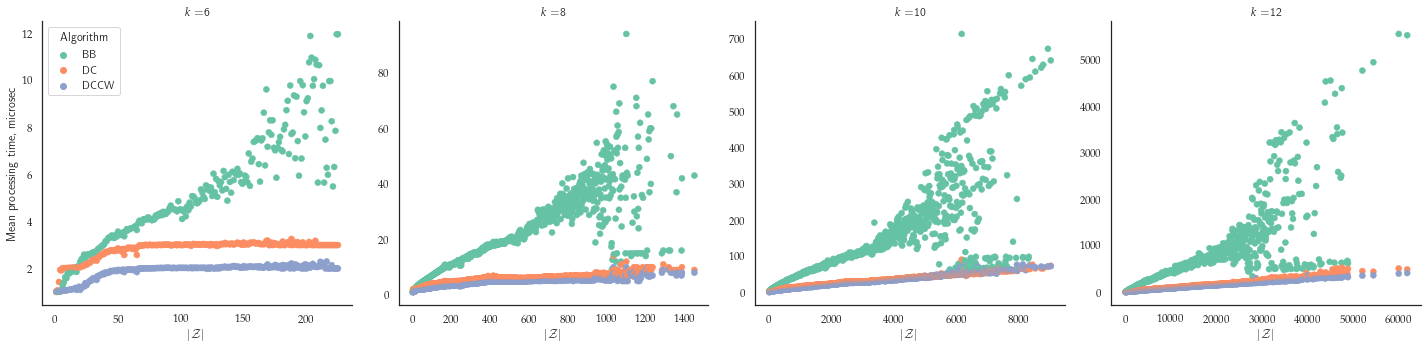

In [217]:
plot2_collection(neotrop, False, sample_size=1000)#filename="img/neotrop.eps")

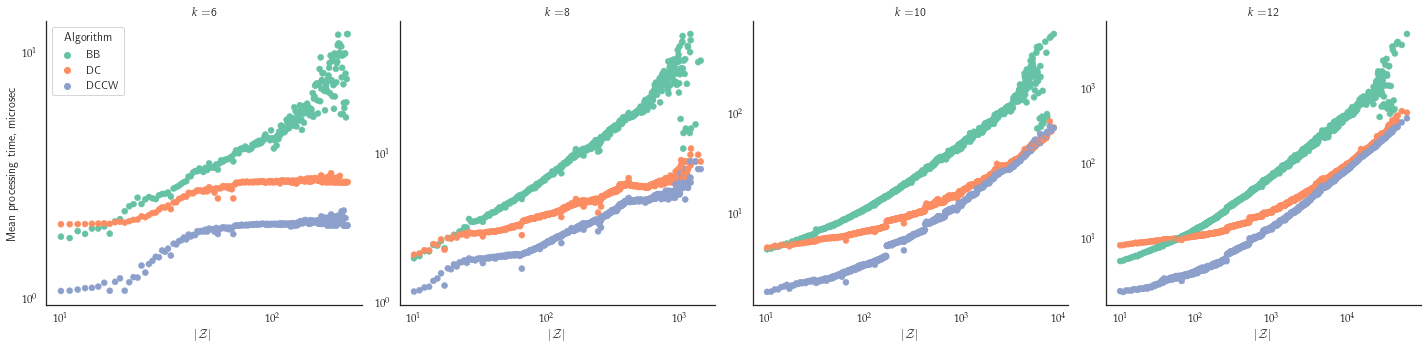

In [218]:
plot2_collection(neotrop, True, sample_size=1000)#filename="img/neotrop.eps")

## Output baseline

How long does it take to *just* output the required number of k-mers to the array? "Baseline" is told the right value of $|Z|$ for a given window, and it outputs this number of threshold values.

In [17]:
neotrop_bl = read_dataset("results/neotrop-baseline.csv")

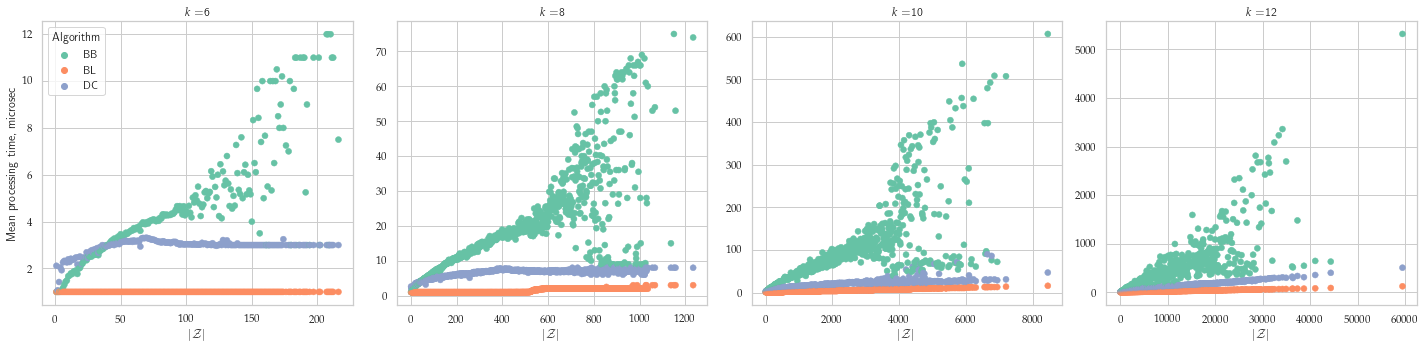

In [18]:
plot2_collection(neotrop_bl, False, sample_size=1000)#filename="img/neotrop.eps")

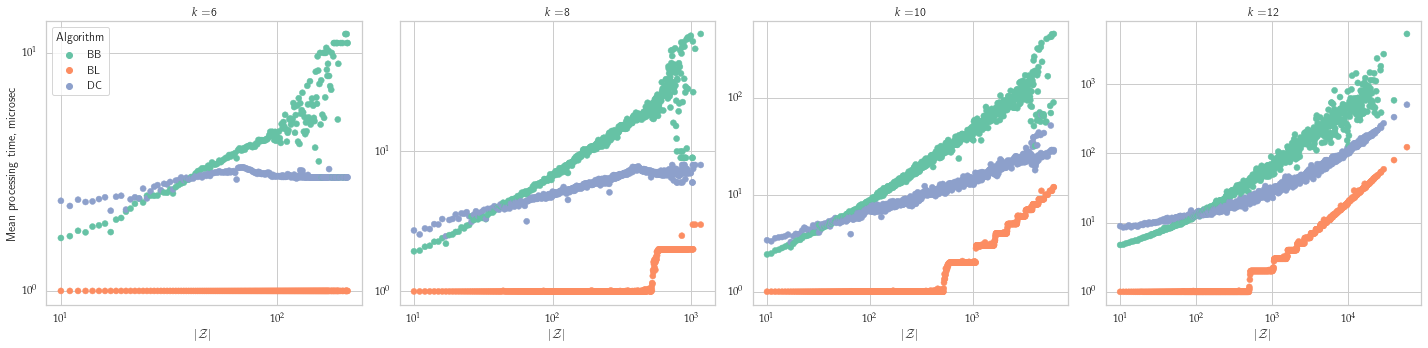

In [19]:
plot2_collection(neotrop_bl, True, sample_size=1000)#filename="img/neotrop.eps")

In [592]:
neotrop_bl_10 = neotrop_bl[neotrop_bl["k"] == 10]
neotrop_bl_10["k"].unique()

array([10])

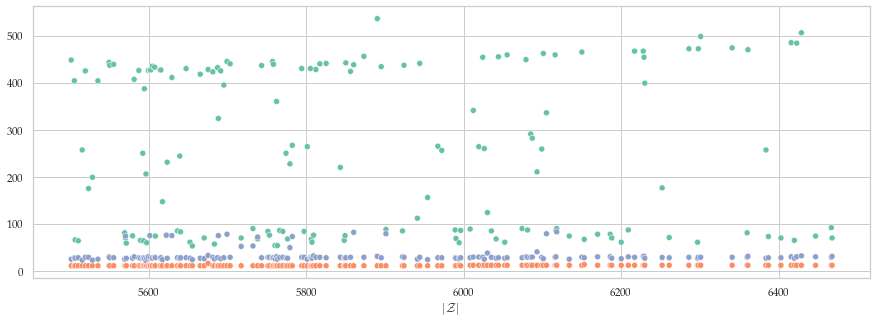

In [593]:
delta = 500
base = 6000
temp = neotrop_bl_10[neotrop_bl_10["num_kmers"].between(base - delta, base + delta)]
plot2(temp, 10, sample_size=10000)

In [594]:
len(temp["position"].unique())

47

In [595]:
bad = temp[(temp["alg"] == "bb") & (temp["time"] > 400)]
bad

alg  num_kmers  time   k  omega      node  position       avg
154914   bb       5629   411  10    1.5  Node2260      1090  0.073015
219750   bb       5699   445  10    1.5  Node2026       238  0.078084
222303   bb       5860   438  10    1.5  Node2026      1089  0.074744
256290   bb       5601   427  10    1.5  Node1980      1186  0.076236
391077   bb       5691   425  10    1.5  Node1836      1187  0.074679
...      ..        ...   ...  ..    ...       ...       ...       ...
3124335  bb       6116   459  10    1.5  Node2413      2481  0.075049
3154239  bb       6150   486  10    1.5  Node1896      1217  0.079024
3187551  bb       5681   423  10    1.5   Node280      1089  0.074459
3191727  bb       5615   427  10    1.5   Node280      2481  0.076046
3356031  bb       5505   404  10    1.5   Node456      1089  0.073388

[69 rows x 8 columns]

In [577]:
bad_nodes = bad["node"].unique()
bad_nodes

array(['Node2260', 'Node2026', 'Node1980', 'Node1836', 'Node1656',
       'Node1342', 'Node1880', 'Node352', 'Node1219', 'Node301',
       'Node987', 'Node1349', 'Node2373', 'Node1004', 'Node1357',
       'Node640', 'Node1431', 'Node1629', 'Node1442', 'Node953',
       'Node1660', 'Node444', 'Node1024', 'Node1508', 'Node890',
       'Node683', 'Node283', 'Node43', 'Node825', 'Node1158', 'Node720',
       'Node1763', 'Node1533', 'Node1652', 'Node971', 'Node2413',
       'Node1896', 'Node280', 'Node456'], dtype=object)

In [600]:
bad_positions = bad["position"].unique()
bad_positions

array([1090,  238, 1089, 1186, 1187, 1475, 1767, 2274, 2481,  261, 1116,
       1218,  325, 1117, 1217])

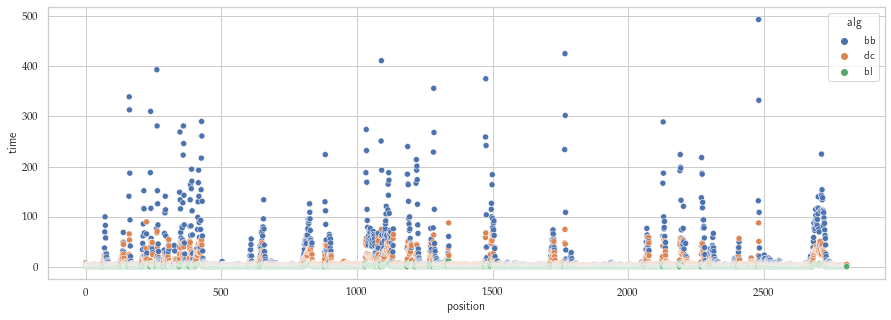

In [601]:
node = bad_nodes[0]
dfnode = neotrop_bl_10[neotrop_bl_10["node"] == node]
sns.scatterplot(data=dfnode, x="position", y="time", hue="alg")

Text(0, 0.5, 'Num kmers')

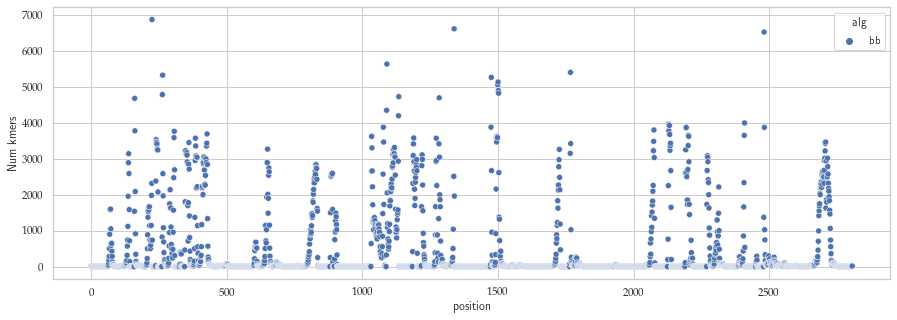

In [602]:
g = sns.scatterplot(data=dfnode[dfnode["alg"] == "bb"], x="position", y="num_kmers", hue="alg")
g.set_ylabel("Num kmers")

In [628]:
def node_plot(df, k, node, yarg="time", ylabel="", position_range=None):
    dfnode = df[(df["k"] == k) & (df["node"] == node)]
    plt.figure(figsize = (12,8))
    
    if position_range:
        dfpos = dfnode[dfnode["position"].between(*position_range)]
    else:
        dfpos = dfnode
    g = sns.scatterplot(data=dfpos, x="position", y=yarg, hue="alg")
    g.set(title=f"Node {node}")
    ylabel = yarg if not ylabel else ylabel
    g.set_ylabel(ylabel)
    

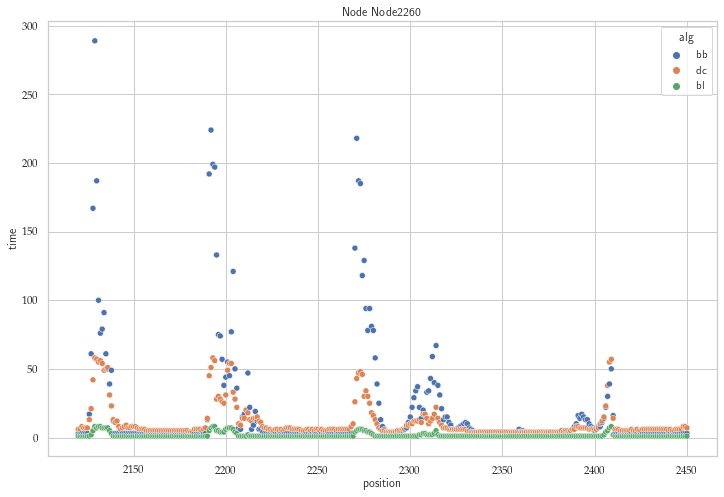

In [634]:
node_plot(dfnode, 10, node, position_range=[2120, 2450], yarg="time")

In [ ]:
node_plot(dfnode, 10, node, position_range=[2120, 2450], yarg="time")

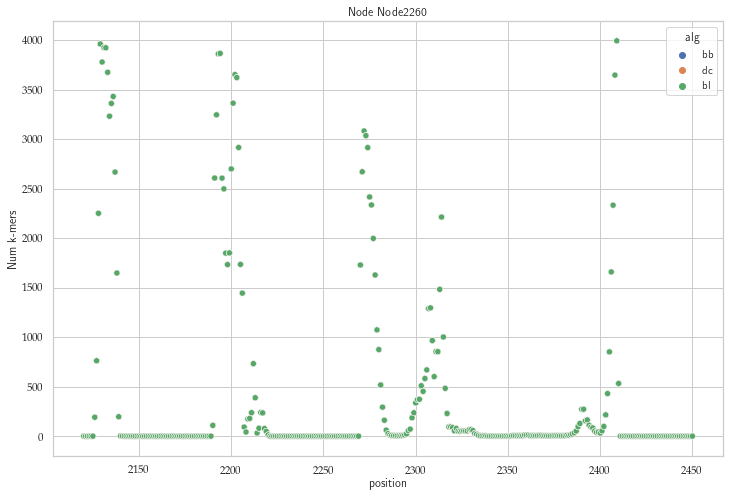

In [636]:
node_plot(dfnode, 10, node, position_range=[2120, 2450], yarg="num_kmers", ylabel="Num k-mers")

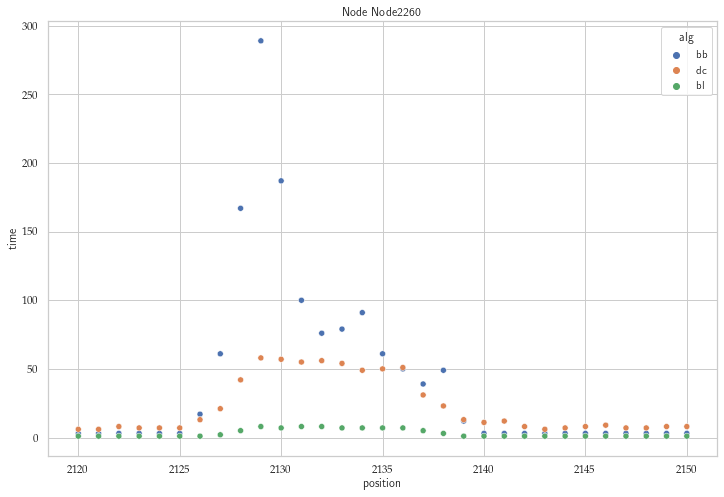

In [637]:
node_plot(dfnode, 10, node, position_range=[2120, 2150], yarg="time")

In [643]:
node_pos_2120 = dfnode[dfnode["position"].between(2120, 2150)]
max_time = node_pos_2120["time"].max()
peak_pos = node_pos_2120[node_pos_2120["time"] == max_time]
peak_pos

alg  num_kmers  time   k  omega      node  position      avg
158031  bb       3960   289  10    1.5  Node2260      2129  0.07298

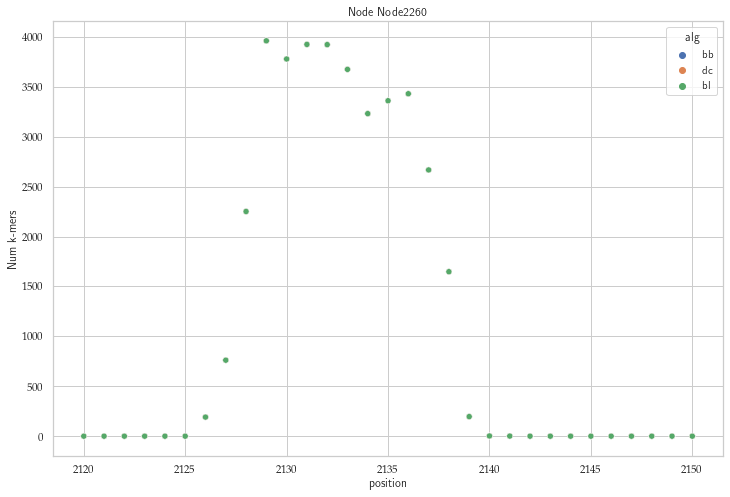

In [631]:
node_plot(dfnode, 10, node, position_range=[2120, 2150], yarg="num_kmers", ylabel="Num k-mers")

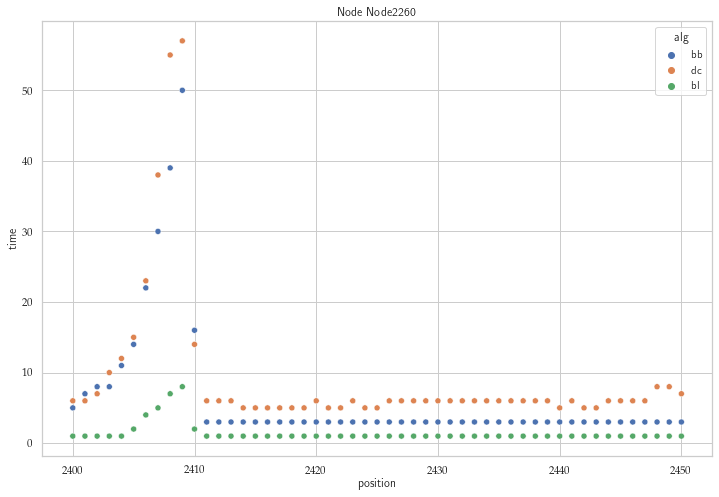

In [632]:
node_plot(dfnode, 10, node, position_range=[2400, 2450], yarg="time")

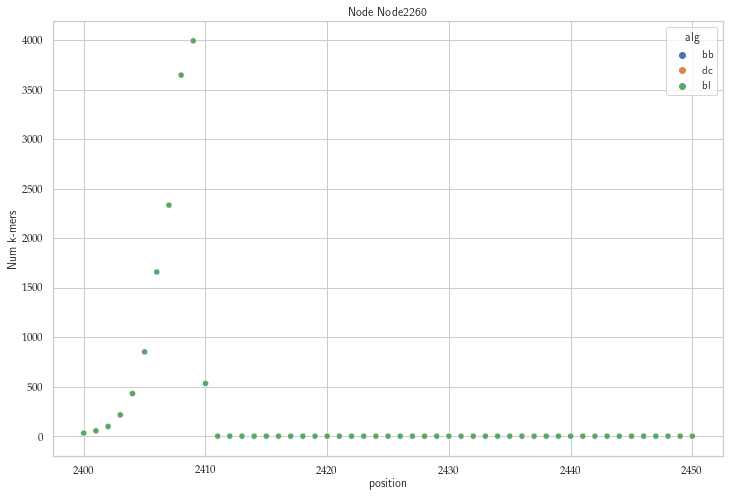

In [633]:
node_plot(dfnode, 10, node, position_range=[2400, 2450], yarg="num_kmers", ylabel="Num k-mers")

In [566]:
dfnode[dfnode["num_kmers"] > 30000]

alg  num_kmers  time   k  omega      node  position       avg
42676140  bb      31879   408  12    1.5  Node1554      2061  0.012798
42676141  dc      31879   255  12    1.5  Node1554      2061  0.007999
42676578  bb      35080  3391  12    1.5  Node1554      2280  0.096665
42676579  dc      35080   295  12    1.5  Node1554      2280  0.008409
42676650  bb      30530  2302  12    1.5  Node1554      2316  0.075401
42676651  dc      30530   231  12    1.5  Node1554      2316  0.007566

In [478]:
temp.groupby(['num_kmers', 'k', 'omega', 'alg']).mean()#.reset_index()

time     position       avg
num_kmers k  omega alg                                   
1         6  1.5   bb     1.000479  1379.688848  1.000479
                   dc     2.106626  1379.688848  2.106626
          8  1.5   bb     1.002042  1380.199066  1.002042
                   dc     2.633084  1380.199066  2.633084
          10 1.5   bb     3.258080  1377.556341  3.258080
...                            ...          ...       ...
4995      10 1.5   bl    28.000000   650.000000  0.005606
          12 1.5   bb    93.000000   407.000000  0.018619
                   dc    62.000000   407.000000  0.012412
4997      12 1.5   bb   309.000000  1982.000000  0.061837
                   dc    97.000000  1982.000000  0.019412

[19121 rows x 3 columns]

## Branch-and-bound with sorted columns

Let us sort columns by entropy for the branch-and-bound algorithm. That is, columns are considered in the order of non-decreasing column entropy $- \sum_{i=0}^{\sigma} M_{i, j} \cdot \log_2 M_{i, j}$. The computation of entropies is not included in the running times below.
### Omega = 1.5

In [712]:
neotrop_bbe = read_dataset("results/neotrop-bbe.csv")
neotrop_bbe

alg  num_kmers  time   k  omega      node  position       avg
0        bb         30    22   6    1.5   Node623         0  0.733333
1       bbe         30     4   6    1.5   Node623         0  0.133333
2        dc         30     7   6    1.5   Node623         0  0.233333
3        bb         15     2   6    1.5   Node623         3  0.133333
4       bbe         15     2   6    1.5   Node623         3  0.133333
...     ...        ...   ...  ..    ...       ...       ...       ...
673915  bbe          2     1  12    1.5  Node1013      2795  0.500000
673916   dc          2     7  12    1.5  Node1013      2795  3.500000
673917   bb          2     4  12    1.5  Node1013      2801  2.000000
673918  bbe          2     1  12    1.5  Node1013      2801  0.500000
673919   dc          2     7  12    1.5  Node1013      2801  3.500000

[673920 rows x 8 columns]

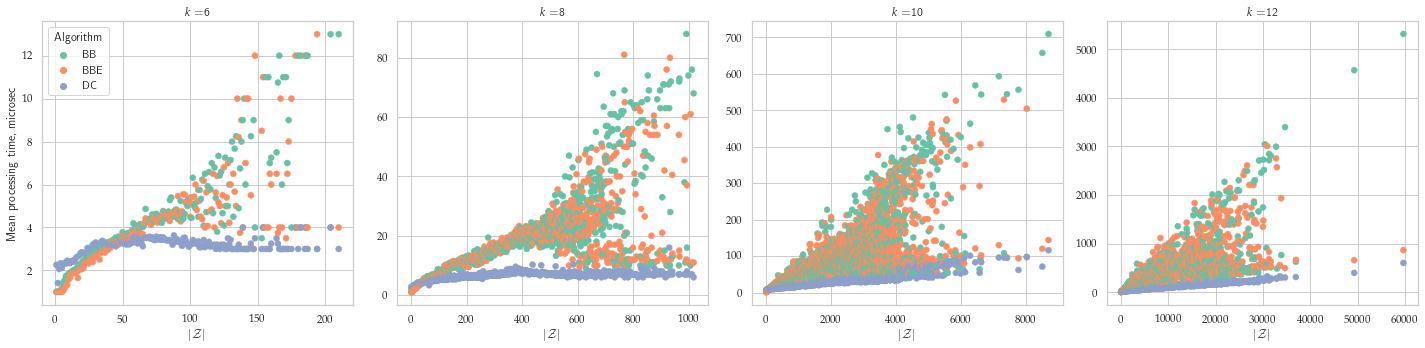

In [706]:
plot2_collection(neotrop_bbe, False)

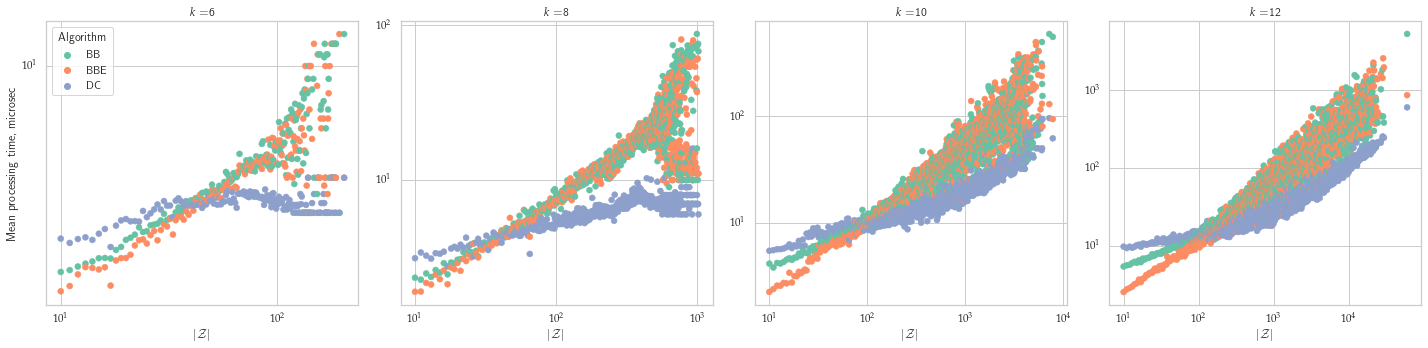

In [707]:
plot2_collection(neotrop_bbe, True)

There is improvement for low values of $|Z|$. But does it matter on the large scale? Let's see total time to compute all nodes of the dataset for different $k$:

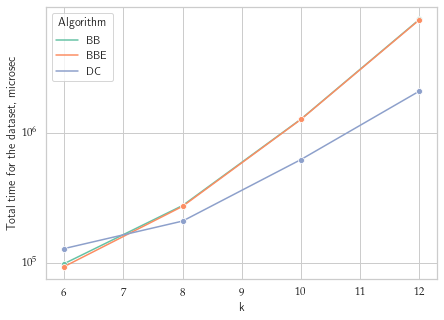

In [715]:
plot_total_time(neotrop_bbe)

### Omega = 1.0

Seems like the sorting trick does not improve the algorithm much... Maybe we just do not have enough of k-mers to see the effect? Let's look at $\omega = 1.0$ (one order of magnitude more k-mers)

In [724]:
neotrop_bbe_o1 = read_dataset("results/neotrop-o1-bbe.csv")
neotrop_bbe_o1

alg  num_kmers  time   k  omega      node  position       avg
0        bb         88    24   6      1  Node1835         0  0.272727
1       bbe         88     4   6      1  Node1835         0  0.045455
2        dc         88    10   6      1  Node1835         0  0.113636
3        bb         30     3   6      1  Node1835         3  0.100000
4       bbe         30     2   6      1  Node1835         3  0.066667
...     ...        ...   ...  ..    ...       ...       ...       ...
252805  bbe          8     2  10      1  Node2076      2799  0.250000
252806   dc          8     5  10      1  Node2076      2799  0.625000
252807   bb         17     3  10      1  Node2076      2804  0.176471
252808  bbe         17     3  10      1  Node2076      2804  0.176471
252809   dc         17     6  10      1  Node2076      2804  0.352941

[252810 rows x 8 columns]

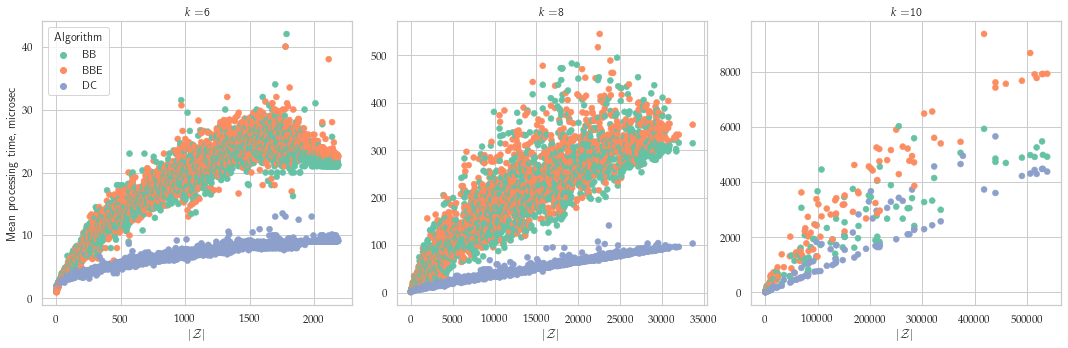

In [725]:
plot2_collection(neotrop_bbe_o1, False)

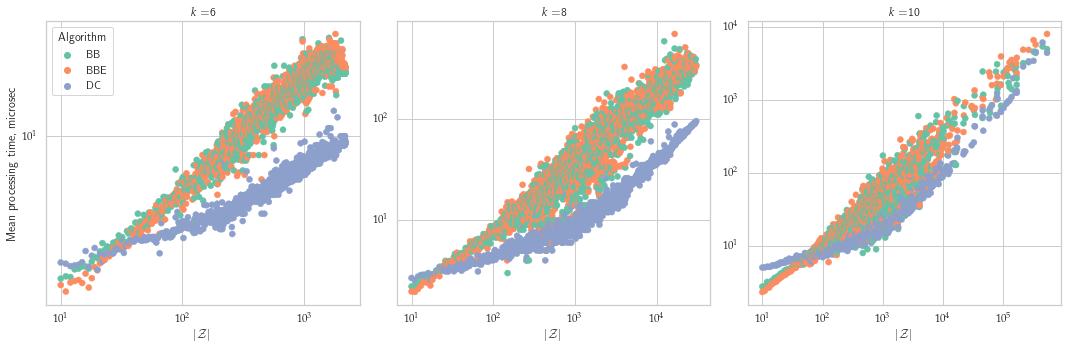

In [726]:
plot2_collection(neotrop_bbe_o1, True)

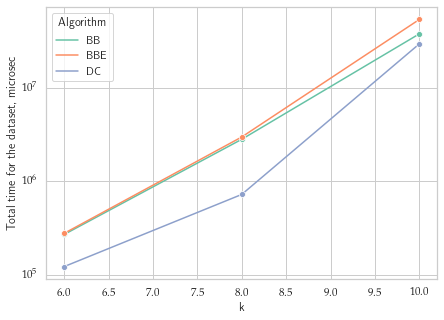

In [727]:
plot_total_time(neotrop_bbe_o1)

That can make things even worse. After seeing this, I ask myself a question: what are the reasons why this trick should improve BB *at all*?

Remark: if we reverse the sorting, it does make the running time consistently worse (a little)

## DCCW

In [657]:
neotrop_cw = pd.read_csv("results/neotrop-dccw.csv")
neotrop_cw["time"] += 1
neotrop_cw["num_kmers"] += 1
neotrop_cw["k"] = neotrop_cw["k"].astype(int)
neotrop_cw["avg"] = neotrop_cw["time"] / neotrop_cw["num_kmers"]

In [658]:
neotrop_cw

alg  num_kmers  time   k  omega      node  position       avg
0         dc          5    23   6    1.5  Node2175         0  4.600000
1       dccw          5     2   6    1.5  Node2175         0  0.400000
2         dc          2     2   6    1.5  Node2175         3  1.000000
3       dccw          2     1   6    1.5  Node2175         3  0.500000
4         dc          2     2   6    1.5  Node2175         6  1.000000
...      ...        ...   ...  ..    ...       ...       ...       ...
449275  dccw        104     6  12    1.5   Node600      2789  0.057692
449276    dc        137    15  12    1.5   Node600      2795  0.109489
449277  dccw        137     6  12    1.5   Node600      2795  0.043796
449278    dc        315    20  12    1.5   Node600      2801  0.063492
449279  dccw        315    10  12    1.5   Node600      2801  0.031746

[449280 rows x 8 columns]

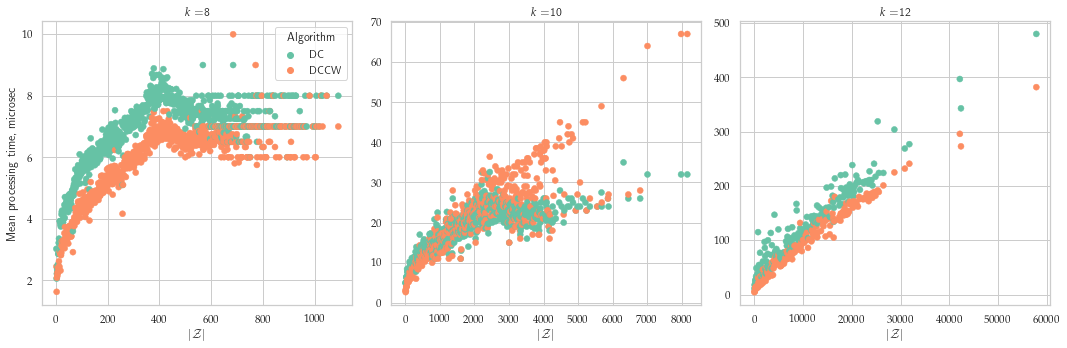

In [659]:
plot2_collection(neotrop_cw, False, sample_size=1000)

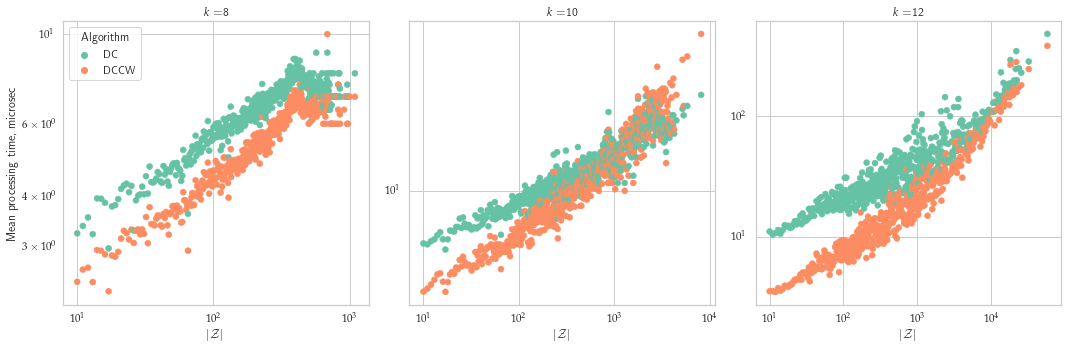

In [660]:
plot2_collection(neotrop_cw, True, sample_size=1000)

In [663]:
neotrop_sum = neotrop_cw.groupby(["k", "alg"]).sum().reset_index()
neotrop_sum

k   alg  num_kmers     time    omega  position            avg
0   6    dc     774727   138598  84330.0  78989100   57677.154526
1   6  dccw     774727   103301  84330.0  78989100   43927.011040
2   8    dc    3994920   207375  84270.0  78876720   64314.323597
3   8  dccw    3994920   170726  84270.0  78876720   52357.208104
4  10    dc   23687990   460574  84210.0  78764420   97636.231711
5  10  dccw   23687990   393790  84210.0  78764420   60831.038055
6  12    dc  149507442  2280570  84150.0  78652200  204914.761305
7  12  dccw  149507442  1556394  84150.0  78652200   76514.444116

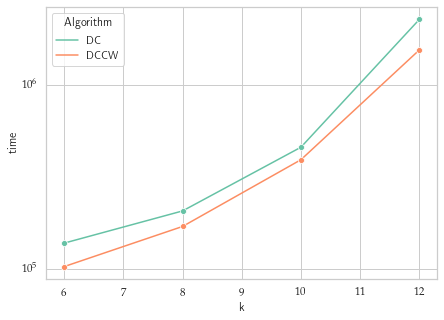

In [672]:
sns.set(rc={'figure.figsize':(7, 5)})
sns.set_style("whitegrid")

pal = palette[:len(neotrop_sum["alg"].unique())]
g = sns.lineplot(data=neotrop_sum, x="k", y="time", hue="alg", palette=pal, marker='o')

g.set_yscale("log")
leg = g.axes.get_legend()
leg.set_title("Algorithm")
tx = leg.texts
for t in tx:
   t.set_text(t.get_text().upper())

# D155 (HCV)

In [154]:
d155 = read_dataset("results/d155-dccw.csv")

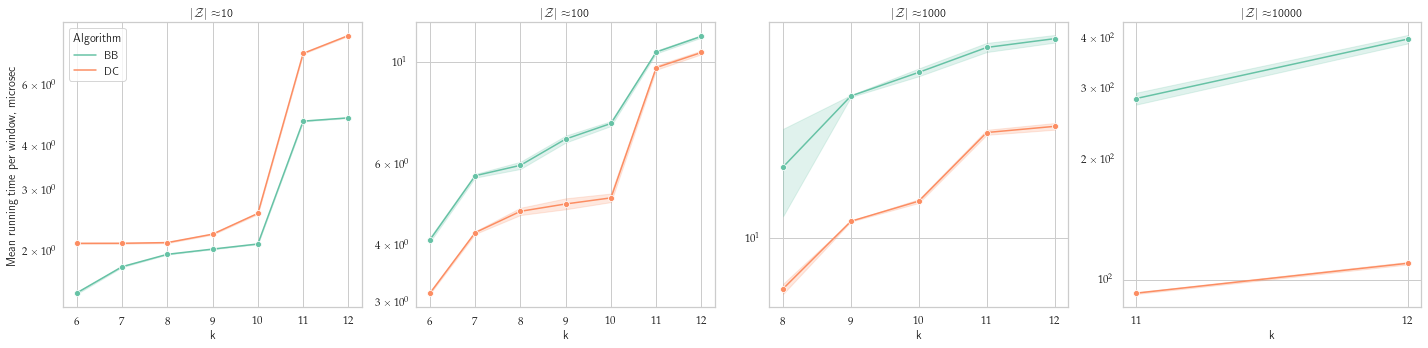

In [329]:
g = plot1_collection(d155)

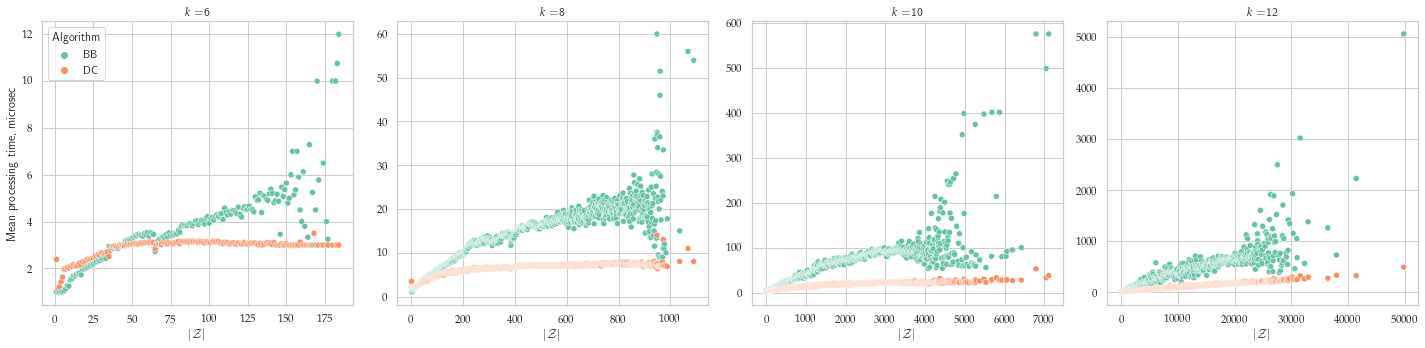

In [317]:
plot3_collection(d155, False)

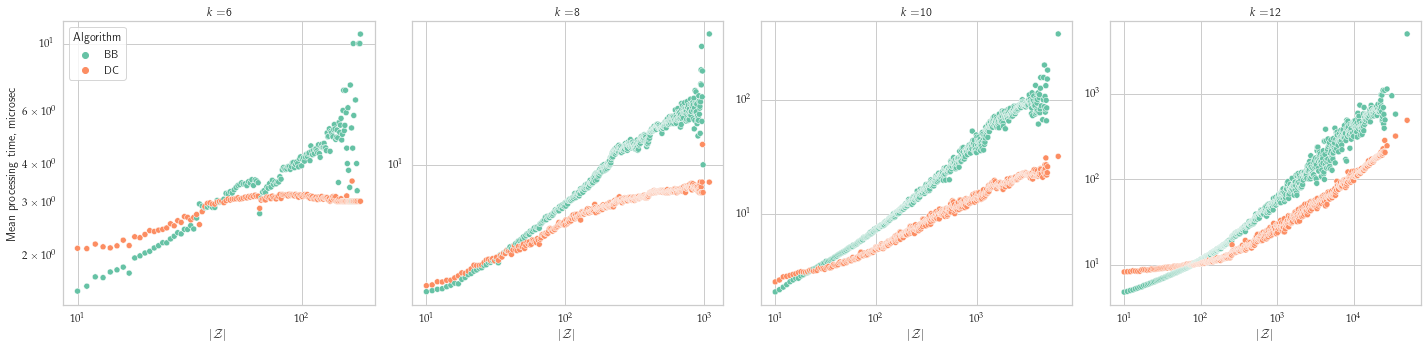

In [318]:
plot3_collection(d155, True)

# Random data (m = 1000)

In [177]:
random = pd.read_csv("results-ghost/random.csv")
random = random[random["k"] == 10]
random["time"] += 1
random["num_kmers"] += 1

In [189]:
def plot_moving_avg_time(df, **kwargs):
    filename = kwargs.get("filename", None)
    
    logy = False
    
    dfx = df.drop(columns=['node', 'position'])
    k_values = [10]

    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111)

    lines = []
    labels = []

    omega_values = dfx["omega"].unique()
    alg_values = dfx["alg"].unique()

    for k, omega, alg in itertools.product(*[k_values, omega_values, alg_values]):
        dfa = dfx[(dfx["k"] == k) & (dfx["omega"] == omega) & (dfx["alg"] == alg)]
        
        window_size = 1000
        df_mean = dfa[["num_kmers", "time"]].set_index("num_kmers").sort_index().rolling(window_size).mean().dropna().reset_index().dropna()#.shift(-50).reset_index()
        df_sem = dfa[["num_kmers", "time"]].set_index("num_kmers").sort_index().rolling(window_size).sem().dropna().reset_index().dropna()#.shift(-50).reset_index()

        #sns.lineplot(x=df_sem["num_kmers"], y=df_mean["time"]-df_sem["time"], color=palette[1], ci=None)
        plt.fill_between(df_mean["num_kmers"], df_mean["time"]- df_sem["time"], df_mean["time"]+df_sem["time"], color=palette[3])
        line = sns.lineplot(x=df_mean["num_kmers"], y=df_mean["time"], color=colors[alg], ci=None)

        #df_rolling = df_rolling[(df_rolling.T != 0.0).any()]
        #line = ax.scatter(df_rolling.num_kmers, df_rolling.time, color=colors[alg], s=1)
        
        lines.append(line)
        labels.append(alg)
        
        if logy:
            ax.set_xscale('log')
            ax.set_yscale('log')

    ax.legend(lines, labels)
    
    leg = ax.get_legend()
    leg.set_title("Algorithm")
    #for handle in leg.legendHandles:
    #    handle.set_markersize(9)
        
    tx = leg.texts
    for t in tx:
       t.set_text(t.get_text().upper())
    
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename)

/tmp/ipykernel_645860/851987178.py:23: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  df_sem = dfa[["num_kmers", "time"]].set_index("num_kmers").sort_index().rolling(window_size).sem().dropna().reset_index().dropna()#.shift(-50).reset_index()
/tmp/ipykernel_645860/851987178.py:23: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  df_sem = dfa[["num_kmers", "time"]].set_index("num_kmers").sort_index().rolling(window_size).sem().dropna().reset_index().dropna()#.shift(-50).reset_index()
/tmp/ipykernel_645860/851987178.py:23: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  df_sem = dfa[["num_kmers", "time"]].set_index("num_kmers").sort_index().rolling(window_size).sem().dropna().reset_in

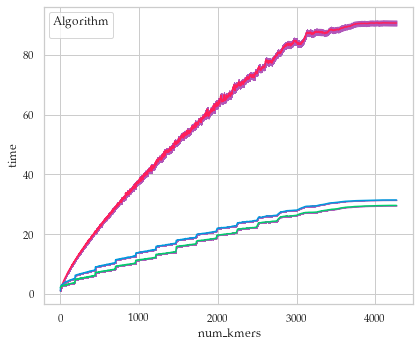

In [190]:
#plot_moving_avg_time(random, filename="img/random-window.pdf")
plot_moving_avg_time(random)

/tmp/ipykernel_645860/441274748.py:4: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  df_sem = dfa[["num_kmers", "time"]].set_index("num_kmers").sort_index().rolling(window_size).sem().dropna().reset_index().dropna()#.shift(-50).reset_index()


<AxesSubplot:xlabel='num_kmers', ylabel='time'>

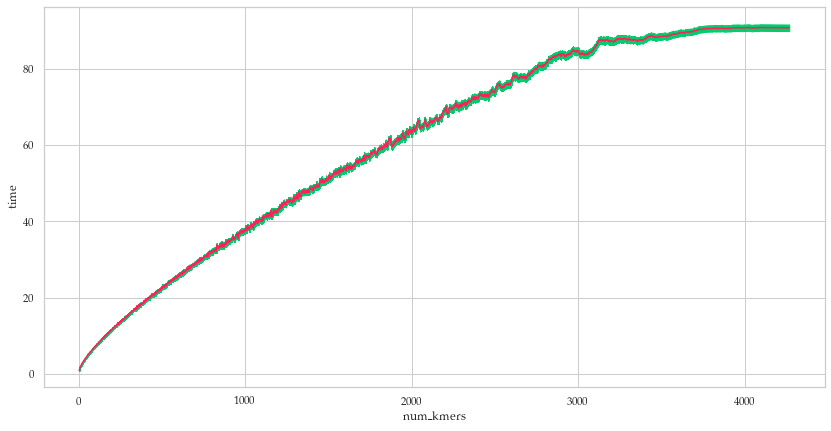

In [171]:
window_size = 1000
dfa = df[df["alg"] == "bb"]
df_mean = dfa[["num_kmers", "time"]].set_index("num_kmers").sort_index().rolling(window_size).mean().dropna().reset_index().dropna()#.shift(-50).reset_index()
df_sem = dfa[["num_kmers", "time"]].set_index("num_kmers").sort_index().rolling(window_size).sem().dropna().reset_index().dropna()#.shift(-50).reset_index()


#sns.lineplot(x=df_sem["num_kmers"], y=df_mean["time"]-df_sem["time"], color=palette[1], ci=None)
plt.fill_between(df_mean["num_kmers"], df_mean["time"]- df_sem["time"], df_mean["time"]+df_sem["time"], color=palette[1])
sns.lineplot(x=df_mean["num_kmers"], y=df_mean["time"], color=palette[0], ci=None)

In [162]:
df_sem

num_kmers      time
0               1  0.000000
1               1  0.000000
2               1  0.000000
3               1  0.000000
4               1  0.000000
...           ...       ...
988996       4088  0.861772
988997       4127  0.861591
988998       4130  0.861508
988999       4190  0.860713
989000       4267  0.860497

[989001 rows x 2 columns]

/home/nikolai/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


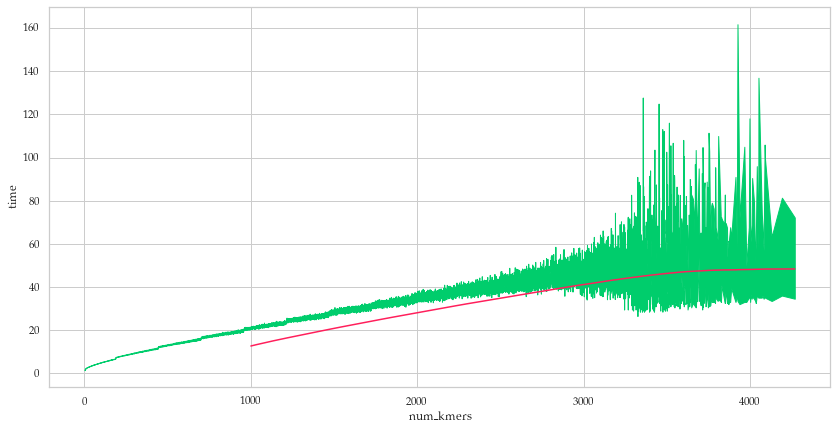

In [90]:
#plt.errorbar(dfmean["num_kmers"], dfmean["time"], dfsem["time"])

sns.lineplot(df_rolling["num_kmers"], df_rolling["time"], color=palette[0])
#plt.scatter(dfmean["num_kmers"], dfmean["time"], color=palette[0])
plt.fill_between(dfmean["num_kmers"], dfmean["time"]-dfsem["time"], dfmean["time"]+dfsem["time"], color=palette[1])
#plt.xscale('log')
#plt.yscale('log')

In [ ]:
df_rolling = dfmean[["num_kmers", "time"]].set_index("num_kmers").sort_index().rolling(1000).mean().dropna().reset_index().dropna()#.shift(-50).reset_index()


/home/nikolai/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


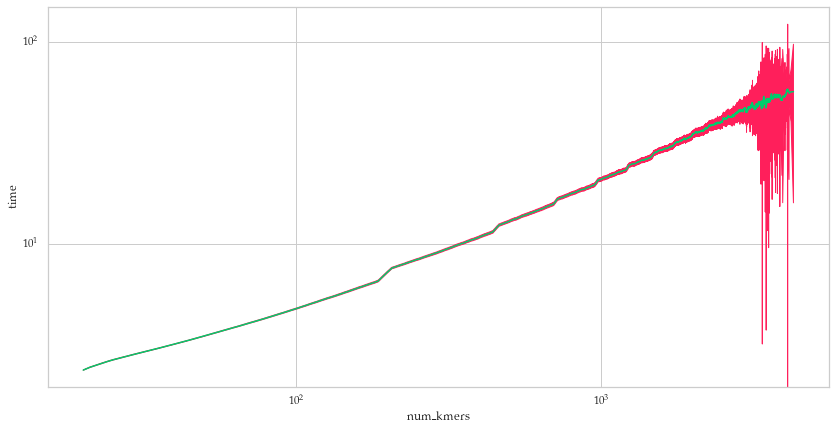

In [142]:
df_rolling = dfmean[["num_kmers", "time"]].set_index("num_kmers").sort_index().rolling(20).mean().dropna().reset_index()

#sns.lineplot(dfmean["num_kmers"], dfmean["time"], color=palette[0])
dfsem_tail = dfsem#[20:]

dfplus = df_rolling["time"]+dfsem_tail["time"]
dfplus.dropna(inplace=True)
dfminus = df_rolling["time"]-dfsem_tail["time"]
dfminus.dropna(inplace=True)
plt.fill_between(df_rolling["num_kmers"], dfminus, dfplus, color=palette[0])

#plt.fill_between(df_rolling["num_kmers"], df_rolling["time"]-dfsem_tail["time"], df_rolling["time"]+dfsem_tail["time"], color=palette[0])
sns.lineplot(df_rolling["num_kmers"], df_rolling["time"], color=palette[1])

plt.xscale('log')
plt.yscale('log')

In [138]:
dfminus

0        2.367469
1        2.438786
2        2.496981
3        2.551559
4        2.607226
          ...    
3621    37.025002
3622    20.866667
3623    47.516667
3624    40.373132
3625    15.982313
Name: time, Length: 3626, dtype: float64

In [139]:
dfplus

0        2.370350
1        2.450431
2        2.508503
3        2.567340
4        2.619564
          ...    
3621    77.041665
3622    92.866667
3623    64.183333
3624    73.060201
3625    97.651020
Name: time, Length: 3626, dtype: float64

In [140]:
df_rolling

num_kmers       time
0            20   2.368910
1            21   2.444608
2            22   2.502742
3            23   2.559449
4            24   2.613395
...         ...        ...
3621       4088  57.033333
3622       4127  56.866667
3623       4130  55.850000
3624       4190  56.716667
3625       4267  56.816667

[3626 rows x 2 columns]

In [127]:
dfsem_tail = dfsem[20:]
df_rolling["time"] - dfsem_tail["time"]

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
3640   NaN
3641   NaN
3642   NaN
3643   NaN
3644   NaN
Name: time, Length: 3645, dtype: float64

In [392]:
#random.sort_values(by=['num_kmers', 'alg'])

nx = neotrop[neotrop["k"] == 10]
dfg = nx.groupby(['num_kmers', 'k', 'omega', 'alg']).mean().reset_index()
dfx = dfg.sort_values(by=['num_kmers', 'alg'])
dfx

num_kmers   k  omega   alg        time     position       avg
0              1  10    1.5    bb    3.014680  1374.242230  3.014680
1              1  10    1.5    dc    3.018826  1374.242230  3.018826
2              1  10    1.5  dccw    1.220358  1374.242230  1.220358
3              2  10    1.5    bb    3.043214  1470.203455  1.521607
4              2  10    1.5    dc    4.044813  1470.203455  2.022407
...          ...  ..    ...   ...         ...          ...       ...
21709       8995  10    1.5    dc   70.000000  1217.000000  0.007782
21710       8995  10    1.5  dccw   76.000000  1217.000000  0.008449
21711       9009  10    1.5    bb  641.000000  1089.000000  0.071151
21712       9009  10    1.5    dc   74.000000  1089.000000  0.008214
21713       9009  10    1.5  dccw   73.000000  1089.000000  0.008103

[21714 rows x 7 columns]

In [394]:
pd.set_option('display.max_rows', None)
#pd.set_option('display.max_rows', 10)

In [395]:
z = dfx[dfx['num_kmers'].between(1, 15)]
z

num_kmers   k  omega   alg      time     position       avg
0           1  10    1.5    bb  3.014680  1374.242230  3.014680
1           1  10    1.5    dc  3.018826  1374.242230  3.018826
2           1  10    1.5  dccw  1.220358  1374.242230  1.220358
3           2  10    1.5    bb  3.043214  1470.203455  1.521607
4           2  10    1.5    dc  4.044813  1470.203455  2.022407
5           2  10    1.5  dccw  1.053856  1470.203455  0.526928
6           3  10    1.5    bb  3.373838  1447.091366  1.124613
7           3  10    1.5    dc  4.052142  1447.091366  1.350714
8           3  10    1.5  dccw  1.102096  1447.091366  0.367365
9           4  10    1.5    bb  3.758899  1393.486241  0.939725
10          4  10    1.5    dc  4.071452  1393.494659  1.017863
11          4  10    1.5  dccw  1.125054  1393.494659  0.281263
12          5  10    1.5    bb  3.805307  1500.326778  0.761061
13          5  10    1.5    dc  4.080155  1500.321573  0.816031
14          5  10    1.5  dccw  1.105811  1500.321573  0.221162
15          6  10    1.5    bb  3.967056  1424.589332  0.661176
16          6  10    1.5    dc  4.140433  1424.589332  0.690072
17          6  10    1.5  dccw  1.190271  1424.589332  0.198378
18          7  10    1.5    bb  4.023355  1397.997119  0.574765
19          7  10    1.5    dc  4.197441  1397.997119  0.599634
20          7  10    1.5  dccw  1.315750  1397.997119  0.187964
21          8  10    1.5    bb  4.168830  1356.127543  0.521104
22          8  10    1.5    dc  4.276437  1356.127543  0.534555
23          8  10    1.5  dccw  1.408528  1356.127543  0.176066
24          9  10    1.5    bb  4.292879  1391.224793  0.476987
25          9  10    1.5    dc  4.378878  1391.224793  0.486542
26          9  10    1.5  dccw  1.492875  1391.224793  0.165875
27         10  10    1.5    bb  4.462241  1361.306118  0.446224
28         10  10    1.5    dc  4.633140  1361.306118  0.463314
29         10  10    1.5  dccw  1.669914  1361.306118  0.166991
30         11  10    1.5    bb  4.524010  1442.822529  0.411274
31         11  10    1.5    dc  4.653974  1442.822529  0.423089
32         11  10    1.5  dccw  1.681289  1442.822529  0.152844
33         12  10    1.5    bb  4.688977  1439.250394  0.390748
34         12  10    1.5    dc  4.836197  1439.250394  0.403016
35         12  10    1.5  dccw  1.767014  1439.250394  0.147251
36         13  10    1.5    bb  4.715454  1350.985614  0.362727
37         13  10    1.5    dc  4.777235  1350.985614  0.367480
38         13  10    1.5  dccw  1.768556  1350.985614  0.136043
39         14  10    1.5    bb  4.891055  1423.721929  0.349361
40         14  10    1.5    dc  4.935081  1423.721929  0.352506
41         14  10    1.5  dccw  1.866906  1423.721929  0.133350
42         15  10    1.5    bb  4.982977  1415.303613  0.332198
43         15  10    1.5    dc  4.937235  1415.303613  0.329149
44         15  10    1.5  dccw  1.896700  1415.303613  0.126447

In [390]:
z = dfx[dfx['num_kmers'] > 4000]
z

num_kmers   k  omega   alg  time  position
10881       4002  10    1.5    bb  73.0     931.0
10882       4002  10    1.5    dc  34.0     931.0
10883       4002  10    1.5  dccw  39.0     931.0
10884       4008  10    1.5    bb  86.0     191.0
10885       4008  10    1.5    dc  34.0     191.0
...          ...  ..    ...   ...   ...       ...
10930       4190  10    1.5    dc  34.0     435.0
10931       4190  10    1.5  dccw  38.0     435.0
10932       4267  10    1.5    bb  91.0     857.0
10933       4267  10    1.5    dc  35.0     857.0
10934       4267  10    1.5  dccw  34.0     857.0

[54 rows x 6 columns]

In [374]:
ax.scatter(df_rolling.num_kmers, df_rolling.time, color=colors[alg], s=1)
ax.legend(lines, labels)
leg = ax.get_legend()
leg.set_title("Algorithm")

KeyboardInterrupt: 

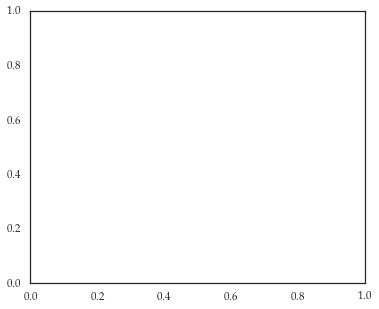

In [202]:
plot_moving_avg_time(neotrop)

/home/nikolai/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


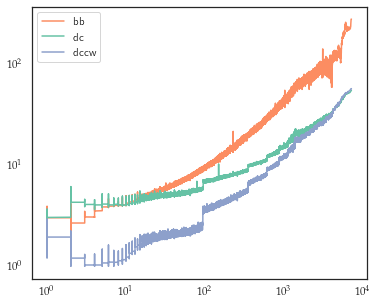

In [155]:
plot_moving_avg_time(d155)

In [449]:
baseline = pd.read_csv("results/baseline.csv")
baseline["time"] += 1
baseline["num_kmers"] += 1
baseline.fillna("bl", inplace=True)
baseline

alg  num_kmers   time   k  omega       node  position
0        bb         48      5   6    1.5  Random100         0
1        dc         48      8   6    1.5  Random100         0
2        bl       3656     23   6    1.5  Random100         0
3        bb         41      3   6    1.5  Random100         1
4        dc         41      5   6    1.5  Random100         1
...      ..        ...    ...  ..    ...        ...       ...
1189195  dc        184     39  12    1.5  Random100       986
1189196  bl    9183683  58325  12    1.5  Random100       986
1189197  bb       3330    197  12    1.5  Random100       987
1189198  dc       3330     66  12    1.5  Random100       987
1189199  bl   11059261  69986  12    1.5  Random100       987

[1189200 rows x 7 columns]

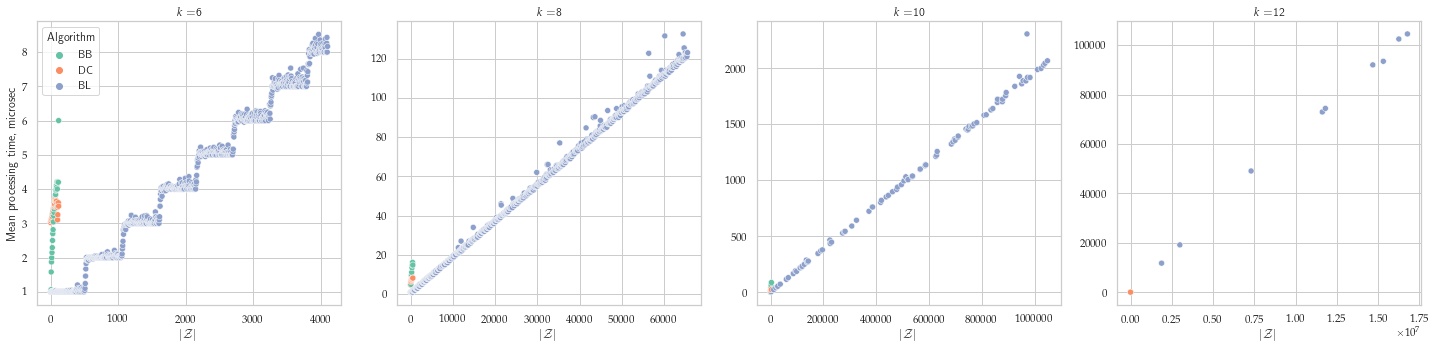

In [450]:
plot3_collection(baseline, False)

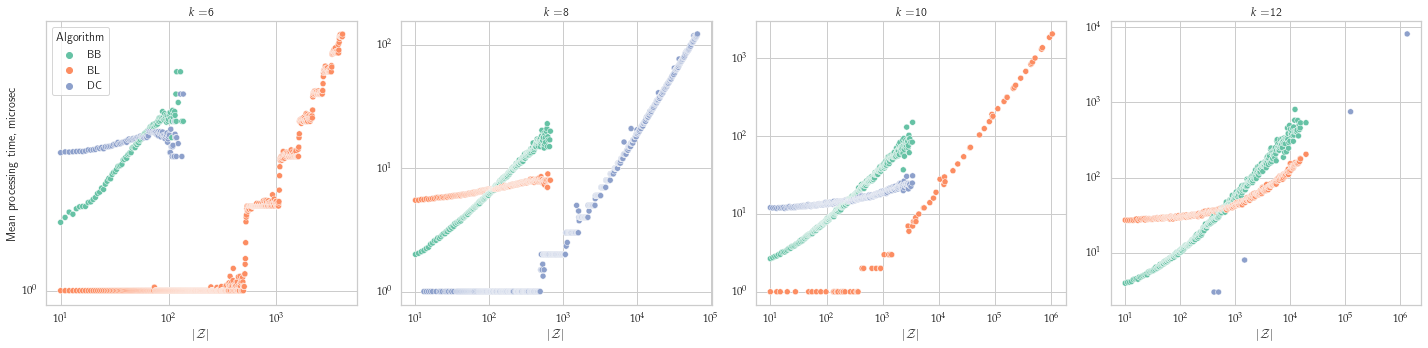

In [451]:
plot3_collection(baseline, True)

In [673]:
random_bbe = pd.read_csv("results/random-bbe.csv")
random_bbe["time"] += 1
random_bbe["num_kmers"] += 1
random_bbe

alg  num_kmers  time   k  omega       node  position
0         bb         48     5   6    1.5  Random100         0
1        bbe         48     4   6    1.5  Random100         0
2         dc         48    10   6    1.5  Random100         0
3         bb         49     3   6    1.5  Random100         3
4        bbe         49     5   6    1.5  Random100         3
...      ...        ...   ...  ..    ...        ...       ...
1189195  bbe       2434   119  12    1.5  Random100       977
1189196   dc       2434    57  12    1.5  Random100       977
1189197   bb       4011   179  12    1.5  Random100       983
1189198  bbe       4011   274  12    1.5  Random100       983
1189199   dc       4011    67  12    1.5  Random100       983

[1189200 rows x 7 columns]

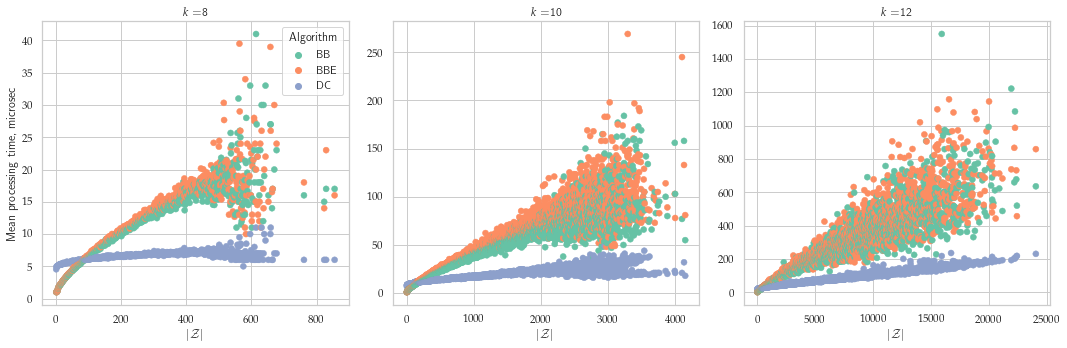

In [675]:
plot2_collection(random_bbe, False)

In [419]:
best = pd.read_csv("results/random-omega-0.csv")
best["time"] += 1
best["num_kmers"] += 1

In [420]:
best

alg  num_kmers  time  k  omega       node  position
0       bb       4097    51  6      0  Random100         0
1       dc       4097    65  6      0  Random100         0
2       bb       4097    31  6      0  Random100         1
3       dc       4097    17  6      0  Random100         1
4       bb       4097    37  6      0  Random100         2
...     ..        ...   ... ..    ...        ...       ...
397195  dc      65537   219  8      0  Random100       989
397196  bb      65537   491  8      0  Random100       990
397197  dc      65537   225  8      0  Random100       990
397198  bb      65537   486  8      0  Random100       991
397199  dc      65537   217  8      0  Random100       991

[397200 rows x 7 columns]

Text(0.5, 0, 'Num k-mers')

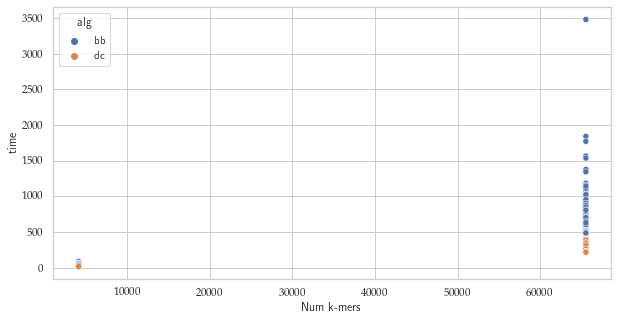

In [435]:
g = sns.scatterplot(data=best, x="num_kmers", y="time", hue="alg")
g.set_xlabel("Num k-mers")

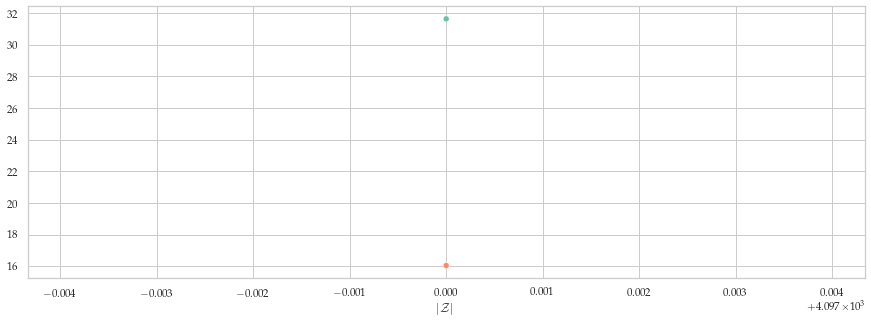

In [428]:
#plot2_collection(best, False, sample_size=1000)



In [326]:
random = pd.read_csv("results/random-100-o1.5.csv")
random["time"] += 1
random["num_kmers"] += 1
random["k"] = random["k"].astype(int)
random["avg"] = random["time"] / random["num_kmers"]

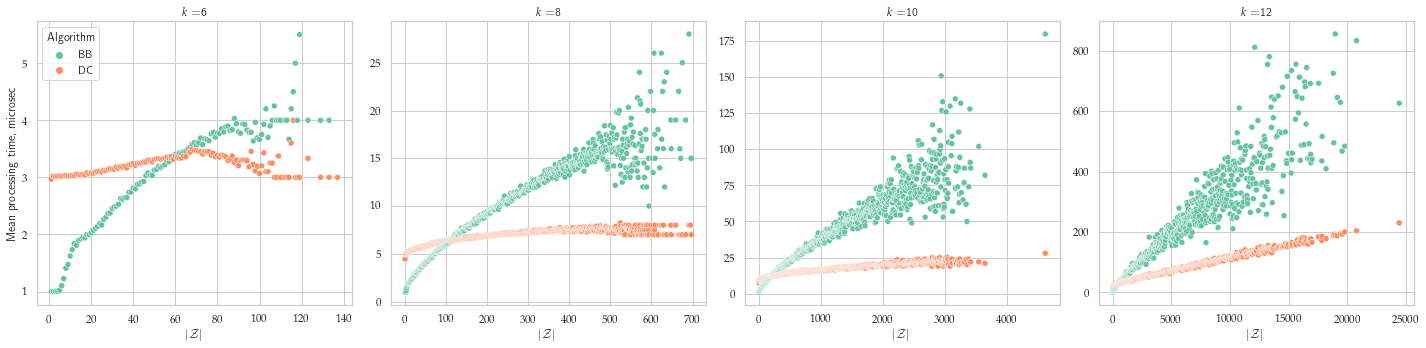

In [327]:
plot3_collection(random, False)

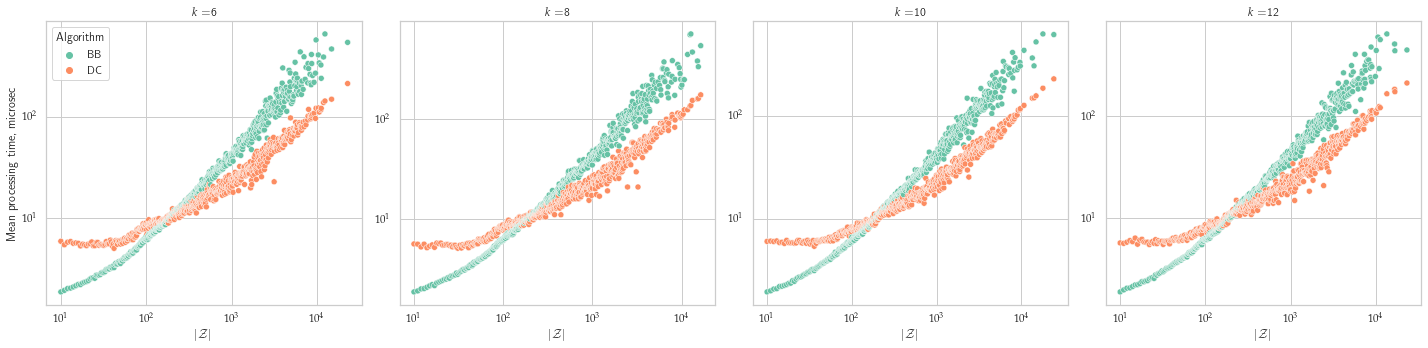

In [324]:
plot3_collection(random, True)

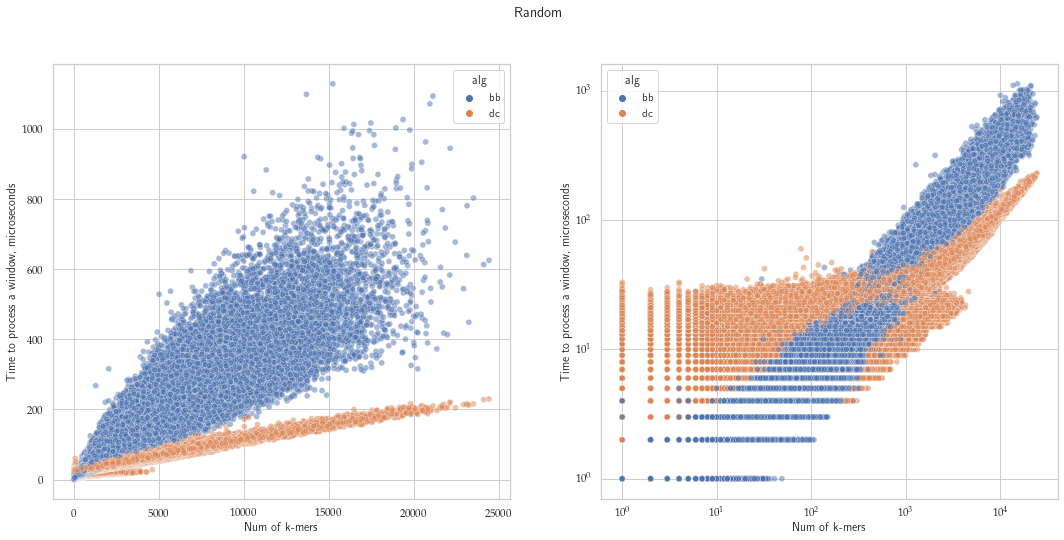

In [325]:
plot(random, 1.5, "Random")

In [ ]:
df = neotrop
max_num_kmers = df["num_kmers"].max()
print(max_num_kmers)
space = np.linspace(1, max_num_kmers, num=10)
print(space)
#dfg = df.groupby(['num_kmers', 'node', 'position', 'k', 'omega', 'alg'])
x = df[df["num_kmers"].isin(space)]
x



# log_max_num_kmers = np.log10(max_num_kmers)

# space = np.linspace(1, max_num_kmers, num=sample_size)
# logspace = np.logspace(1, log_max_num_kmers, num=sample_size)

# if logy:
#     df_rarefied = dfg[dfg["num_kmers"].isin(logspace)]
# else:
#     df_rarefied = dfg[dfg["num_kmers"].isin(space)]


# fig, axs = plt.subplots(ncols=2)
# fig.set_size_inches(2 * 5, 5)

# #dfo = df[df["omega"] == omega]
# if stylek:
#     g1 = sns.scatterplot(x="num_kmers", y="time", hue="alg", style="k", data=df, ax=axs[0], alpha=0.5)
#     g2 = sns.scatterplot(x="num_kmers", y="time", hue="alg", style="k", data=df, ax=axs[1], alpha=0.5)
# else:
#     g1 = sns.scatterplot(x="num_kmers", y="time", hue="alg", data=df, ax=axs[0], alpha=alpha)
#     g2 = sns.scatterplot(x="num_kmers", y="time", hue="alg", data=df, ax=axs[1], alpha=alpha)

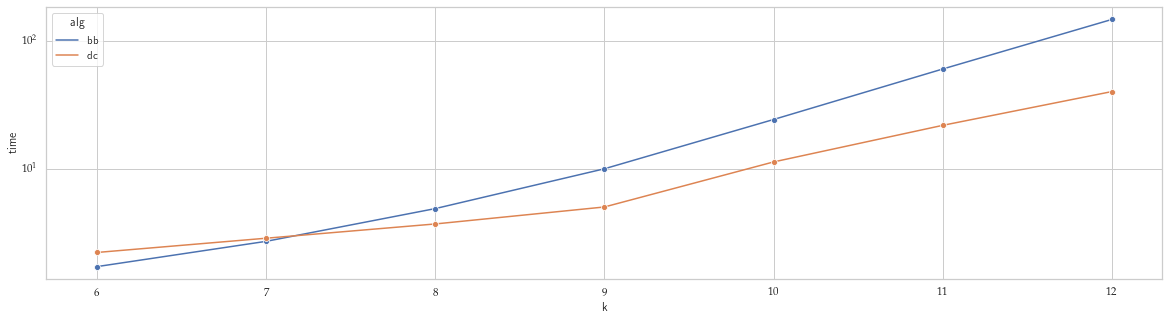

In [255]:
omega = 1.5
dfo = df[df.omega == omega]
dfg = dfo.groupby(['omega', 'k', 'alg']).mean().reset_index()

dfg["ratio"] = dfg["num_kmers"] / (4 ** dfg["k"])
g = sns.lineplot(data=dfg, x="k", y="time", hue="alg", marker='o')
g.set_yscale("log")
#g.set_xscale("log")

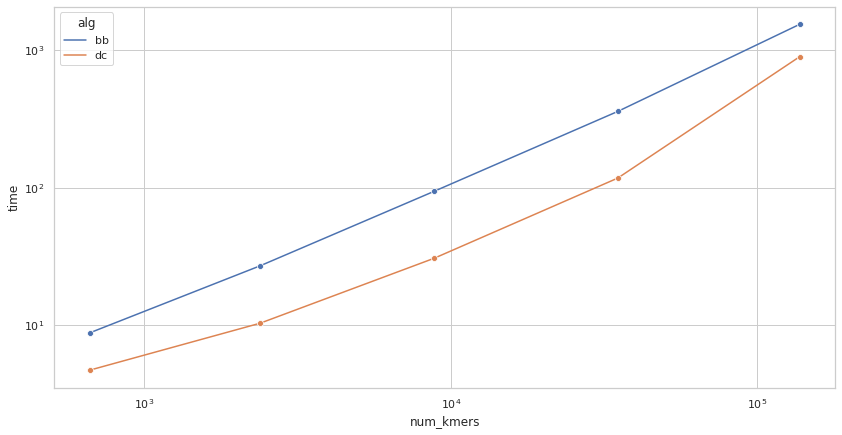

In [893]:
g = sns.lineplot(data=dfg, x="num_kmers", y="time", hue="alg", marker='o')
g.set_yscale("log")
g.set_xscale("log")

In [895]:
df["node"].unique()

array(['Node2192', 'Node2029', 'Node1998', 'Node2019', 'Node2255',
       'Node1836', 'Node1751', 'Node2113', 'Node2093', 'Node1703',
       'Node486', 'Node1635', 'Node1821', 'Node1540', 'Node1781',
       'Node2207', 'Node686', 'Node1399', 'Node1190', 'Node1263',
       'Node1999', 'Node1552', 'Node1141', 'Node1939', 'Node248',
       'Node2094', 'Node1715', 'Node39', 'Node2323', 'Node180',
       'Node2126', 'Node2455', 'Node2174', 'Node1051', 'Node2184',
       'Node588', 'Node2006', 'Node1519', 'Node1881', 'Node2256',
       'Node1531', 'Node716', 'Node1118', 'Node2501', 'Node2002',
       'Node745', 'Node1196', 'Node633', 'Node2531', 'Node1063',
       'Node2515', 'Node2239', 'Node972', 'Node2431', 'Node2497',
       'Node731', 'Node1778', 'Node987', 'Node2041', 'Node669',
       'Node2530', 'Node90', 'Node1028', 'Node1617', 'Node765',
       'Node1567', 'Node1949', 'Node849', 'Node2406', 'Node960',
       'Node482', 'Node871', 'Node1570', 'Node113', 'Node166', 'Node881',
       

In [604]:
dfdc = df[df["alg"] == "dc"]
dfdc[dfdc["time"] > 10000]

alg  num_kmers   time   k  omega      node  position       avg
22725  dc     529571  10131  10      1  Node1596       134  0.019131
22727  dc     529571  10118  10      1  Node1596       135  0.019106
22729  dc     529571  10109  10      1  Node1596       136  0.019089
22731  dc     529571  10146  10      1  Node1596       137  0.019159
22733  dc     529571  10081  10      1  Node1596       138  0.019036
...    ..        ...    ...  ..    ...       ...       ...       ...
52615  dc     529612  10150  10      1   Node935      1044  0.019165
52617  dc     528248  10025  10      1   Node935      1045  0.018978
52653  dc     525711  10544  10      1   Node935      1063  0.020057
52917  dc     528265  11548  10      1   Node935      1195  0.021860
52951  dc     526139  10742  10      1   Node935      1212  0.020417

[939 rows x 8 columns]

In [617]:
dfdc[dfdc["time"] < 2000]

alg  num_kmers  time   k  omega      node  position       avg
1      dc        105    21  10      1  Node2251         0  0.200000
3      dc         57     9  10      1  Node2251         1  0.157895
5      dc         34     5  10      1  Node2251         2  0.147059
7      dc         34     5  10      1  Node2251         3  0.147059
9      dc         34     8  10      1  Node2251         4  0.235294
...    ..        ...   ...  ..    ...       ...       ...       ...
56131  dc      10493    60  10      1   Node935      2802  0.005718
56133  dc      14335    65  10      1   Node935      2803  0.004534
56135  dc      18118    96  10      1   Node935      2804  0.005299
56137  dc      18277    83  10      1   Node935      2805  0.004541
56139  dc      28138   103  10      1   Node935      2806  0.003661

[26651 rows x 8 columns]

## Running time depends on the tree node

For this node, DC shows higher times on k-mer rich regions:

A distant node, branch length ~16. Close to two leafs.

In [637]:
df["position"].max()

2806

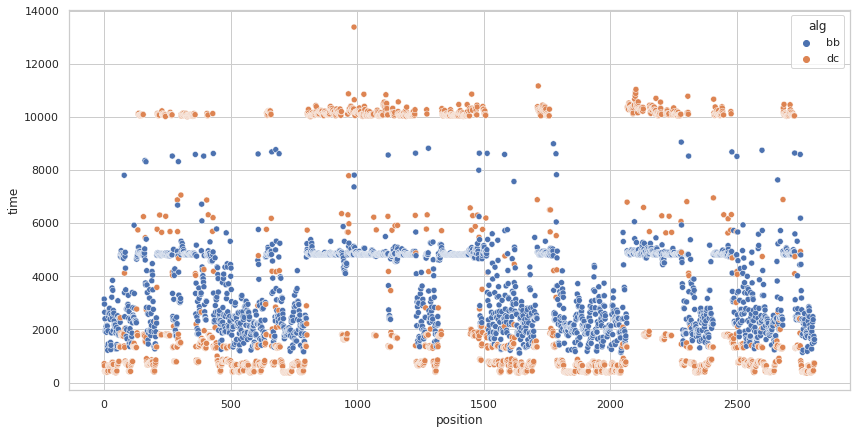

In [633]:
node = "Node1596"
dfnode = df[df["node"] == node]
sns.scatterplot(data=dfnode, x="position", y="time", hue="alg")

/home/nikolai/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


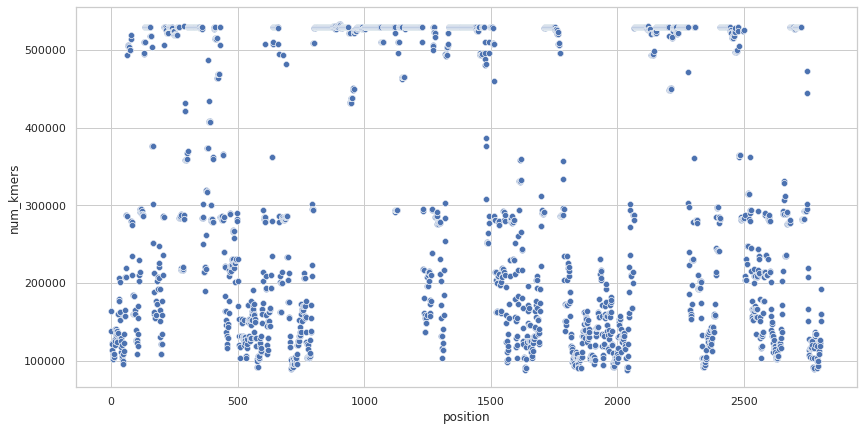

In [634]:
sns.scatterplot(dfnode["position"], dfnode["num_kmers"])

**The picture above concides very accurately with the percentage identity of columns of the alignment**.

1) High variety and many gaps => high number of k-mers and higher time of DC
1) Conservative regions => low number of k-mers and lower time of DC

Let us look at another example. Almost the root node, branch length 0.19. The situation is the opposite: for k-mer rich regions BB shows higher time than DC.

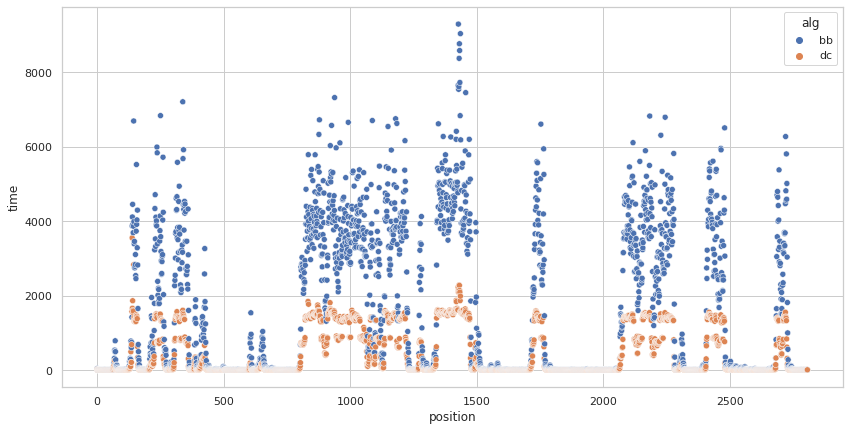

In [630]:
node = "Node2251"
dfnode = df[df["node"] == node]
sns.scatterplot(data=dfnode, x="position", y="time", hue="alg")

/home/nikolai/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


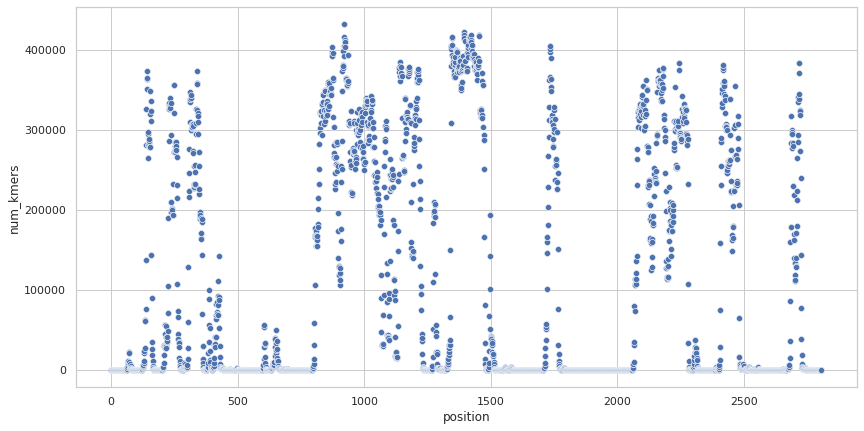

In [629]:
sns.scatterplot(dfnode["position"], dfnode["num_kmers"])

Almost the root node:

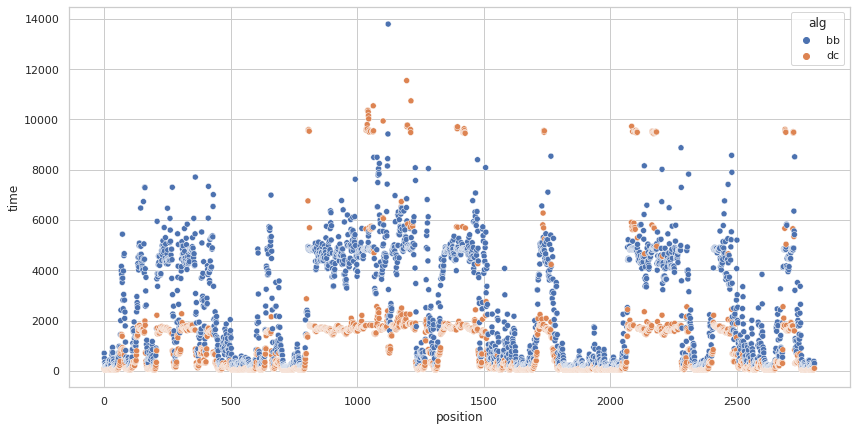

In [635]:
node = "Node935"
dfnode = df[df["node"] == node]
sns.scatterplot(data=dfnode, x="position", y="time", hue="alg")

/home/nikolai/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


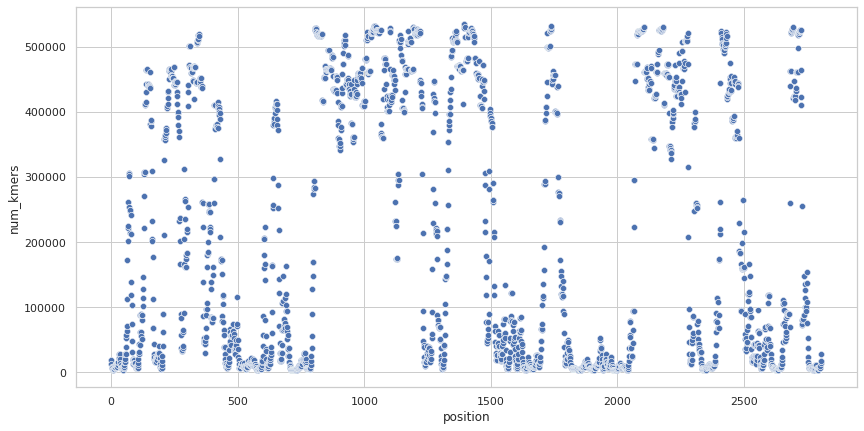

In [636]:
sns.scatterplot(dfnode["position"], dfnode["num_kmers"])

## More nodes

In [148]:
df = pd.read_csv("results/neotrop-100.csv")
df["time"] += 1
df["num_kmers"] += 1
df["avg"] = df["time"] / df["num_kmers"]
#df = df[df["k"] == 10]

In [149]:
omega = 1.0
dfo = df[df.omega == omega]
dfg = dfo.groupby(['omega', 'k', 'alg']).mean().reset_index()

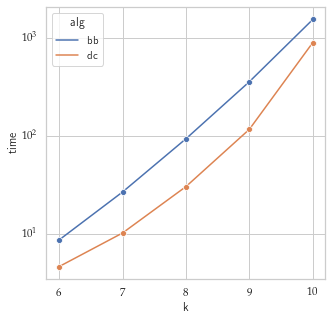

In [147]:
dfg["ratio"] = dfg["num_kmers"] / (4 ** dfg["k"])
g = sns.lineplot(data=dfg, x="k", y="time", hue="alg", marker='o')
g.set_yscale("log")
#g.set_xscale("log")

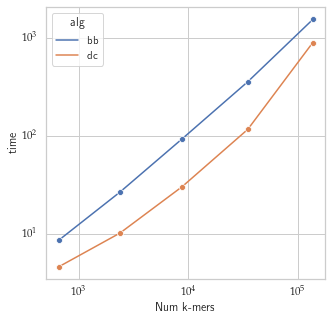

In [107]:
g = sns.lineplot(data=dfg, x="num_kmers", y="time", hue="alg", marker='o')
g.set_xlabel("Num k-mers")
g.set_yscale("log")
g.set_xscale("log")

In [790]:
#omega = 1.0
#plot(df[df["k"] == 10], omega, f"Neotrop-100, omega={omega}", True)

In [151]:
dfg = df.groupby(['num_kmers', 'k', 'omega', 'alg']).mean().reset_index()
dfg

num_kmers   k  omega alg         time     position       avg
0               2   6      1  bb     1.000826  1448.616257  0.500413
1               2   6      1  dc     1.054172  1448.616257  0.527086
2               2   7      1  bb     1.000576  1455.105868  0.500288
3               2   7      1  dc     1.718113  1455.105868  0.859056
4               2   8      1  bb     1.000408  1480.038772  0.500204
...           ...  ..    ...  ..          ...          ...       ...
471686     536749  10      1  dc  7128.000000  1013.000000  0.013280
471687     536822  10      1  bb  6575.000000  1011.000000  0.012248
471688     536822  10      1  dc  7153.000000  1011.000000  0.013325
471689     538579  10      1  dc  2255.000000   154.000000  0.004187
471690     538580  10      1  bb  4265.000000   154.000000  0.007919

[471691 rows x 7 columns]

In [134]:
k = 10
g = sns.scatterplot(data=df[df["k"] == k], x='num_kmers', y='time', hue='alg')
g.set_xlabel("Num k-mers")
g.set_yscale("log")
g.set_xscale("log")

Error in callback <function flush_figures at 0x7fba06dc0680> (for post_execute):


KeyboardInterrupt: 

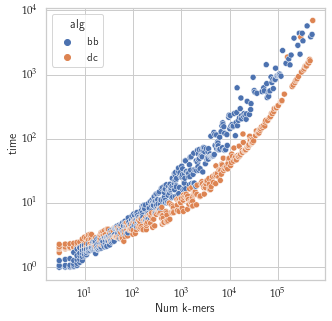

In [142]:
space = np.logspace(1, 6, num=1000)
rarefied = dfg[dfg.index.isin(space)]

g = sns.scatterplot(data=rarefied, x='num_kmers', y='time', hue='alg')
g.set_xlabel("Num k-mers")
g.set_yscale("log")
g.set_xscale("log")

Text(0.5, 0, 'Num k-mers')

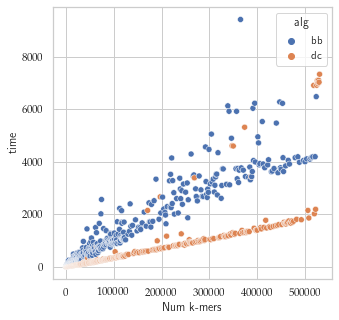

In [152]:
space = np.linspace(0, df["num_kmers"].max(), num=1000)
rarefied = dfg[dfg.index.isin(space)]
g = sns.scatterplot(data=rarefied, x='num_kmers', y='time', hue='alg')
g.set_xlabel("Num k-mers")
#g.set_yscale("log")
#g.set_xscale("log")

In [906]:
dfg = df.groupby(['node', 'alg', 'k']).mean().reset_index()
dfg

node alg   k      num_kmers         time  omega  position       avg
0    Node1028  bb   6    1143.868018    12.769121    1.0    1405.0  0.017706
1    Node1028  bb   7    4045.237011    40.513879    1.0    1404.5  0.015369
2    Node1028  bb   8   14916.300107   145.228907    1.0    1404.0  0.013929
3    Node1028  bb   9   60419.321225   578.220085    1.0    1403.5  0.013289
4    Node1028  bb  10  241490.811186  2470.250445    1.0    1403.0  0.013383
..        ...  ..  ..            ...          ...    ...       ...       ...
995   Node987  dc   6     347.461757     3.350053    1.0    1405.0  0.273889
996   Node987  dc   7    1267.451601     6.828826    1.0    1404.5  0.401625
997   Node987  dc   8    4655.550374    17.839445    1.0    1404.0  0.372932
998   Node987  dc   9   17185.613604    57.325499    1.0    1403.5  0.331451
999   Node987  dc  10   63615.546491   225.431421    1.0    1403.0  0.302020

[1000 rows x 8 columns]

In [907]:
df_time = df.pivot_table(index=['node', 'k', 'position'], columns='alg', values='time').reset_index()#.drop(["alg"], axis=1)
df_time

alg          node   k  position  bb  dc
0        Node1028   6         0  11   6
1        Node1028   6         1  11   5
2        Node1028   6         2   8   5
3        Node1028   6         3   7   4
4        Node1028   6         4   5   4
...           ...  ..       ...  ..  ..
1404495   Node987  10      2802   2   3
1404496   Node987  10      2803   2   3
1404497   Node987  10      2804   2   3
1404498   Node987  10      2805   2   3
1404499   Node987  10      2806   2   3

[1404500 rows x 5 columns]

In [908]:
len(df_time[df_time["bb"] > df_time["dc"]]) / len(df_time)

0.6211071555713777

In [909]:
bad = df_time[df_time["bb"] < df_time["dc"]]
len(bad["node"].unique()), bad["node"].unique()

(100,
 array(['Node1028', 'Node1051', 'Node1063', 'Node1118', 'Node113',
        'Node1141', 'Node1144', 'Node1190', 'Node1196', 'Node1213',
        'Node1263', 'Node1356', 'Node1366', 'Node1391', 'Node1399',
        'Node1519', 'Node1531', 'Node1540', 'Node1552', 'Node1567',
        'Node1570', 'Node1574', 'Node1617', 'Node1635', 'Node166',
        'Node1690', 'Node1703', 'Node1715', 'Node172', 'Node1751',
        'Node1778', 'Node1781', 'Node180', 'Node182', 'Node1821',
        'Node1836', 'Node1881', 'Node1916', 'Node1939', 'Node1949',
        'Node1998', 'Node1999', 'Node2002', 'Node2006', 'Node2007',
        'Node2019', 'Node2029', 'Node2041', 'Node2093', 'Node2094',
        'Node2113', 'Node2126', 'Node2127', 'Node2174', 'Node2184',
        'Node2192', 'Node2207', 'Node2208', 'Node2239', 'Node2255',
        'Node2256', 'Node2301', 'Node2323', 'Node2406', 'Node2431',
        'Node2455', 'Node248', 'Node2497', 'Node2501', 'Node2515',
        'Node2530', 'Node2531', 'Node2550', 'Nod

In [910]:
df_mean_time = df.groupby(['node', 'k', 'alg']).mean().pivot_table(index=['node', 'k', 'position'], columns='alg', values='time').reset_index()
df_mean_time

alg      node   k  position           bb           dc
0    Node1028   6    1405.0    12.769121     6.692280
1    Node1028   7    1404.5    40.513879    15.600356
2    Node1028   8    1404.0   145.228907    49.373443
3    Node1028   9    1403.5   578.220085   203.531339
4    Node1028  10    1403.0  2470.250445  1471.257570
..        ...  ..       ...          ...          ...
495   Node987   6    1405.0     5.985770     3.350053
496   Node987   7    1404.5    17.403203     6.828826
497   Node987   8    1404.0    56.767889    17.839445
498   Node987   9    1403.5   200.738960    57.325499
499   Node987  10    1403.0   720.951906   225.431421

[500 rows x 5 columns]

In [911]:
bad = df_mean_time[df_mean_time["bb"] < df_mean_time["dc"]].node.unique()
bad, len(bad)

(array(['Node1751', 'Node2255'], dtype=object), 2)

In [912]:
good = df_mean_time[df_mean_time["bb"] >= df_mean_time["dc"]].node.unique()
good, len(good)

(array(['Node1028', 'Node1051', 'Node1063', 'Node1118', 'Node113',
        'Node1141', 'Node1144', 'Node1190', 'Node1196', 'Node1213',
        'Node1263', 'Node1356', 'Node1366', 'Node1391', 'Node1399',
        'Node1519', 'Node1531', 'Node1540', 'Node1552', 'Node1567',
        'Node1570', 'Node1574', 'Node1617', 'Node1635', 'Node166',
        'Node1690', 'Node1703', 'Node1715', 'Node172', 'Node1751',
        'Node1778', 'Node1781', 'Node180', 'Node182', 'Node1821',
        'Node1836', 'Node1881', 'Node1916', 'Node1939', 'Node1949',
        'Node1998', 'Node1999', 'Node2002', 'Node2006', 'Node2007',
        'Node2019', 'Node2029', 'Node2041', 'Node2093', 'Node2094',
        'Node2113', 'Node2126', 'Node2127', 'Node2174', 'Node2184',
        'Node2192', 'Node2207', 'Node2208', 'Node2239', 'Node2255',
        'Node2256', 'Node2301', 'Node2323', 'Node2406', 'Node2431',
        'Node2455', 'Node248', 'Node2497', 'Node2501', 'Node2515',
        'Node2530', 'Node2531', 'Node2550', 'Node287',

In [913]:
def node_plot(df, k, node, yarg="time", position_range=None):
    dfnode = df[(df["k"] == k) & (df["node"] == node)]
    plt.figure(figsize = (30,8))
    
    if position_range:
        dfpos = dfnode[dfnode["position"].between(*position_range)]
    else:
        dfpos = dfnode
    sns.scatterplot(data=dfpos, x="position", y=yarg, hue="alg").set(title=f"Node {node}")
    
    
    

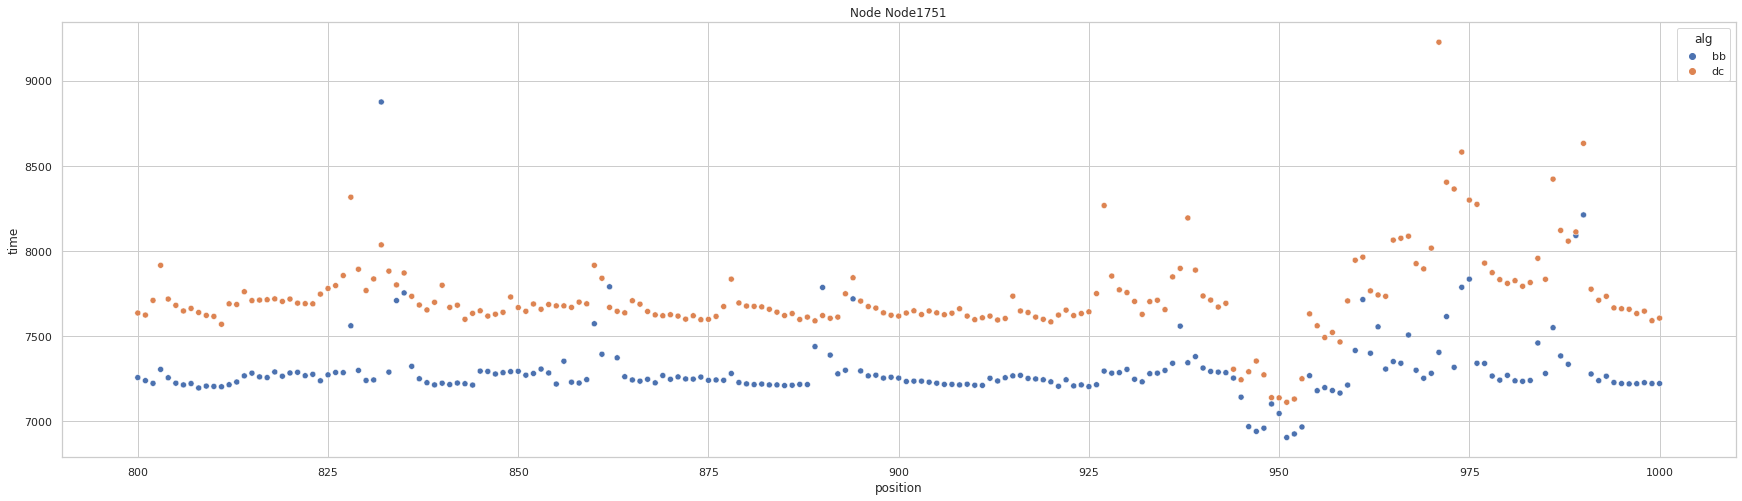

In [914]:
node = bad[0]
k = 10
node_plot(df, k, node, "time", [800, 1000])
#node_plot(df, k, node)

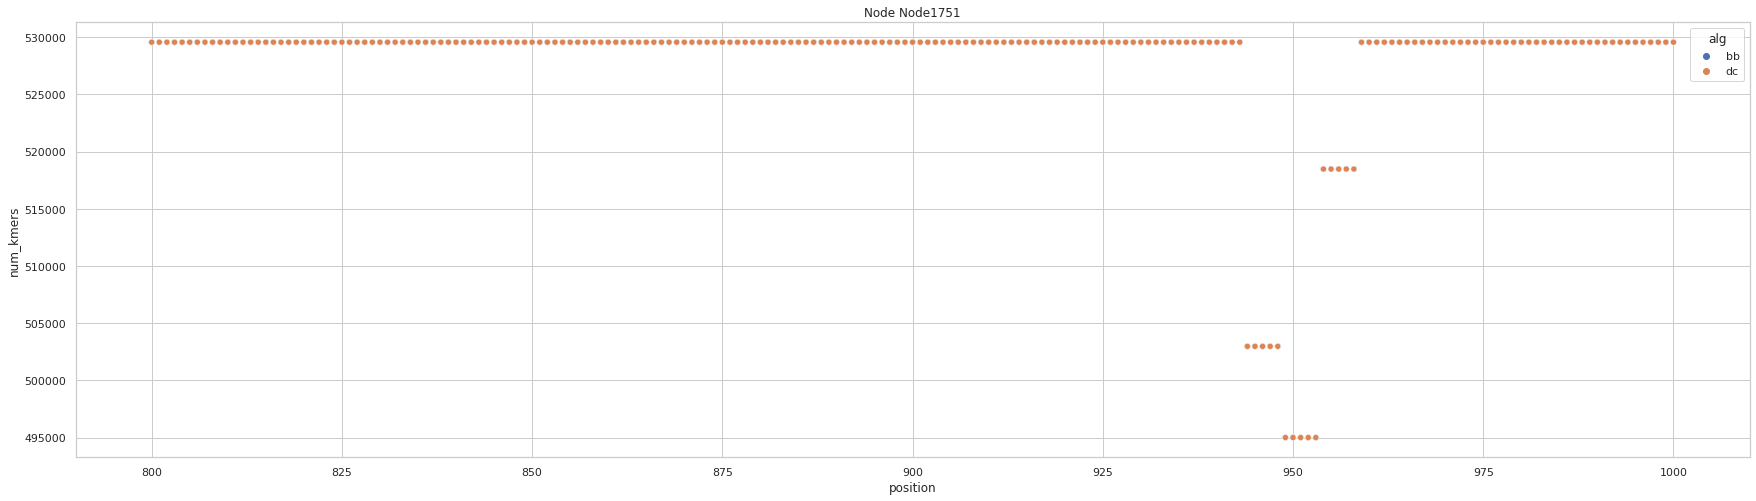

In [915]:
node_plot(df, k, node, "num_kmers", [800, 1000])

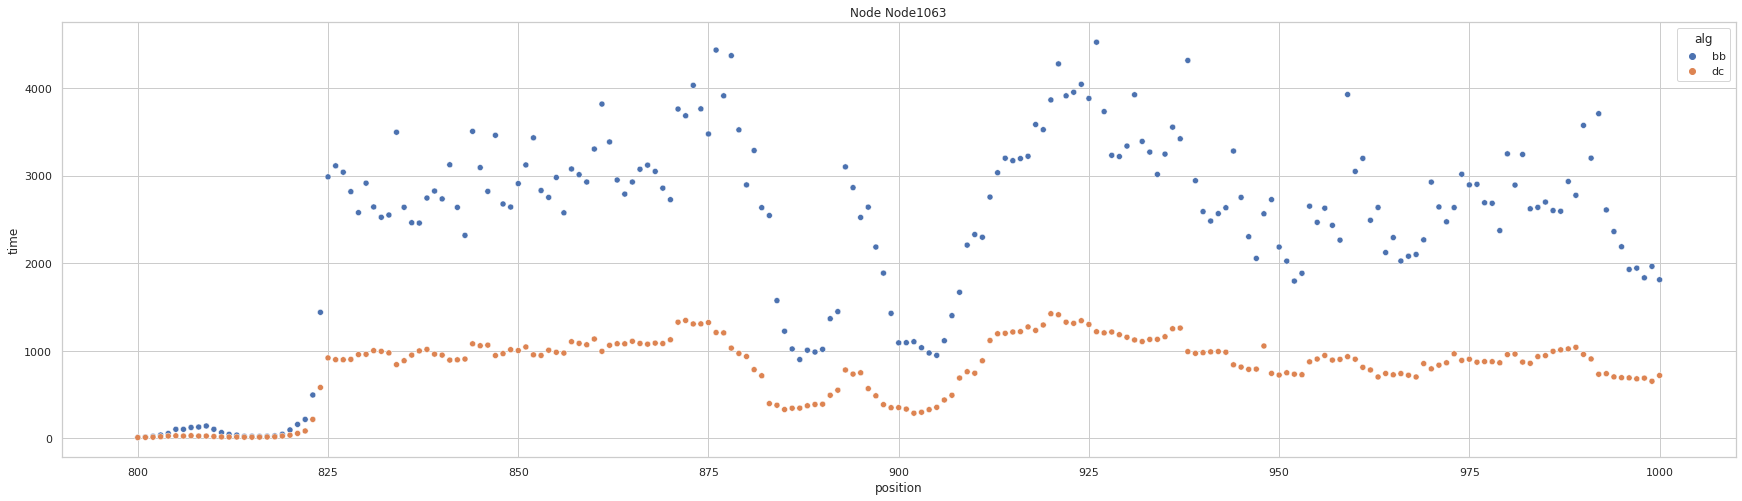

In [916]:
node = good[2]

node_plot(df, k, node, "time", [800, 1000])

## What is happening to DC when time > 7k

In [921]:
df_bad = df[df["time"] > 7000]
bad7k = df_bad["node"].unique()
bad7k

array(['Node2019', 'Node2255', 'Node1836', 'Node1751', 'Node2113',
       'Node486', 'Node1635', 'Node686', 'Node1190', 'Node1552',
       'Node1939', 'Node39', 'Node2184', 'Node2006', 'Node2256',
       'Node1531', 'Node1118', 'Node1196', 'Node633', 'Node2431',
       'Node2497', 'Node731', 'Node669', 'Node1028', 'Node960', 'Node166',
       'Node657', 'Node1213', 'Node86', 'Node339', 'Node2007', 'Node492',
       'Node2208', 'Node2550', 'Node1916', 'Node1391', 'Node386'],
      dtype=object)

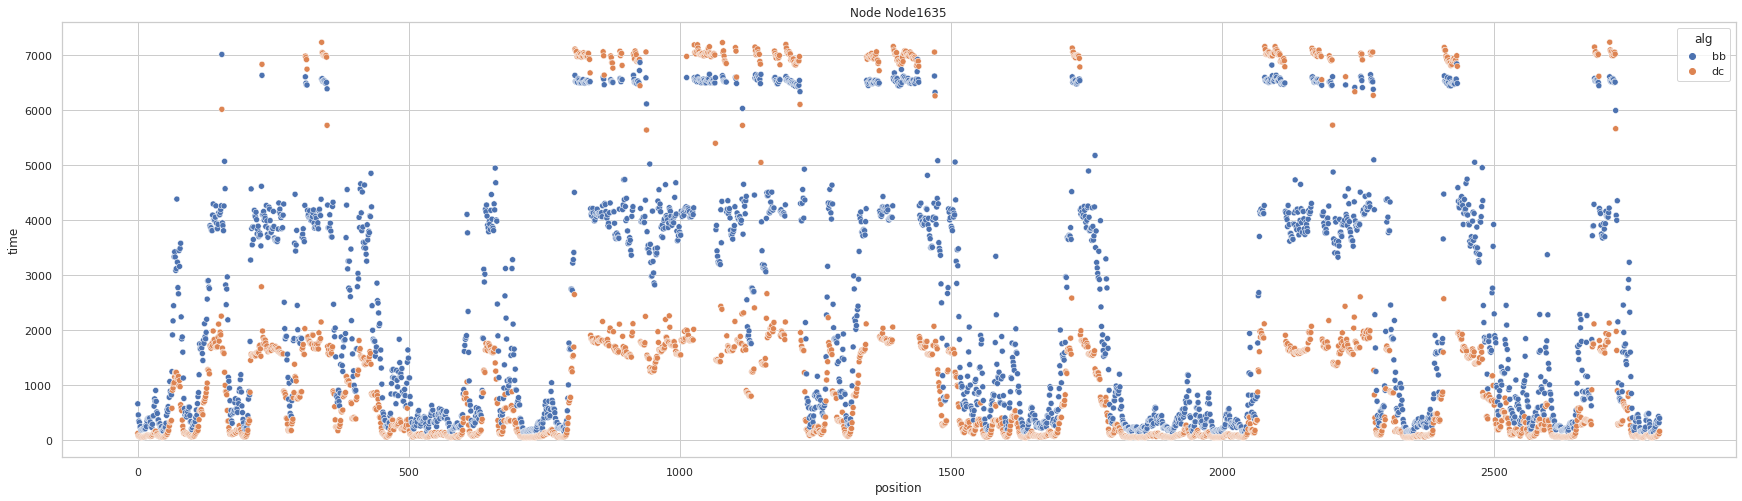

In [927]:
node = bad7k[6]

k = 10
node_plot(df, k, node, "time")

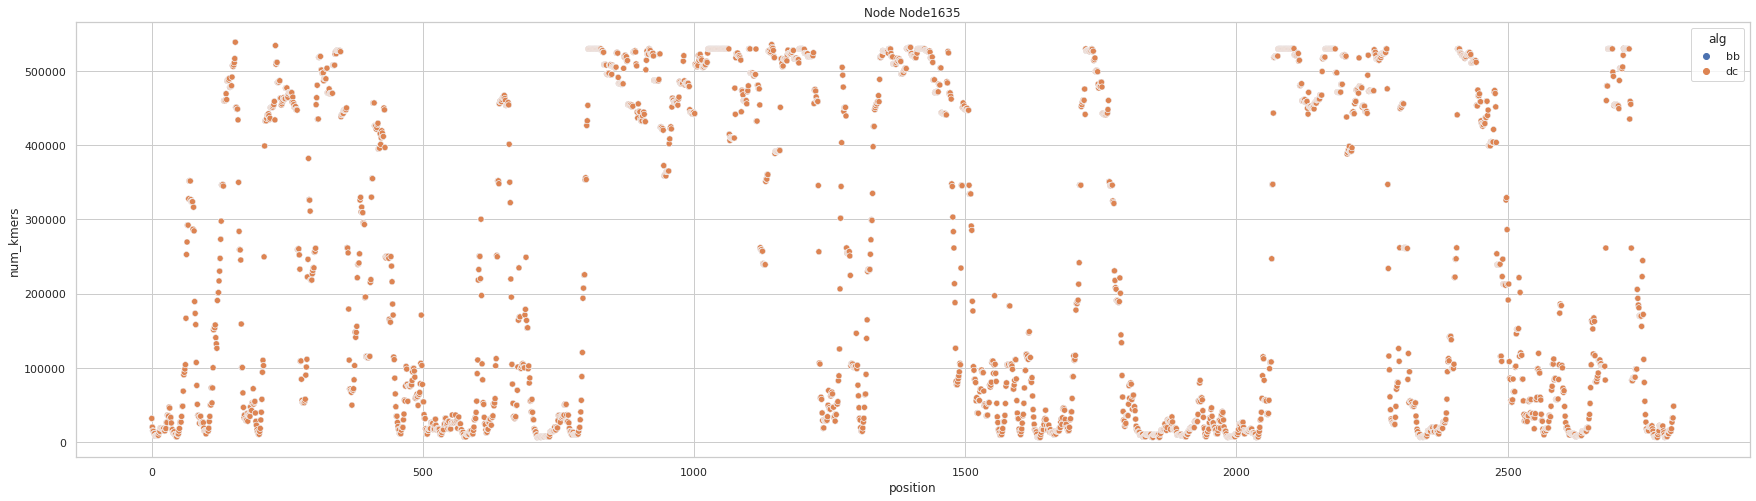

In [928]:
node_plot(df, k, node, "num_kmers")

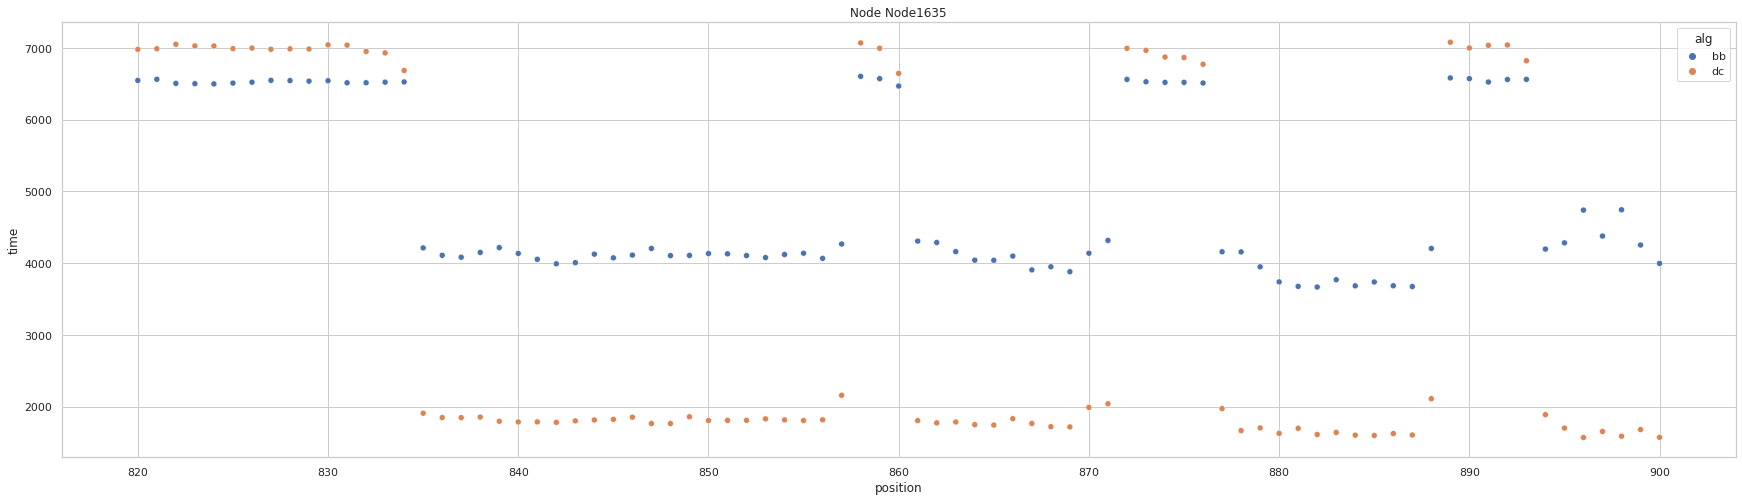

In [931]:
node_plot(df, k, node, "time", [820, 900])

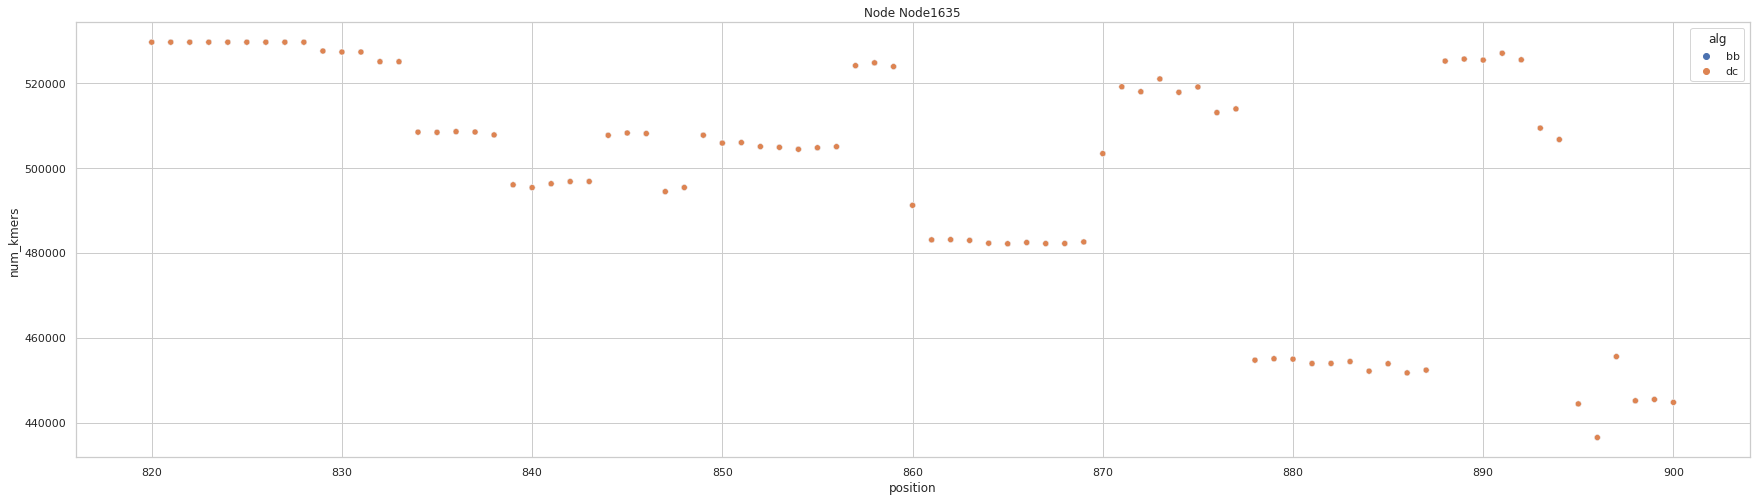

In [932]:
node_plot(df, k, node, "num_kmers", [820, 900])

## Random data

In [734]:
random = read_dataset("results/random-dccw.csv")

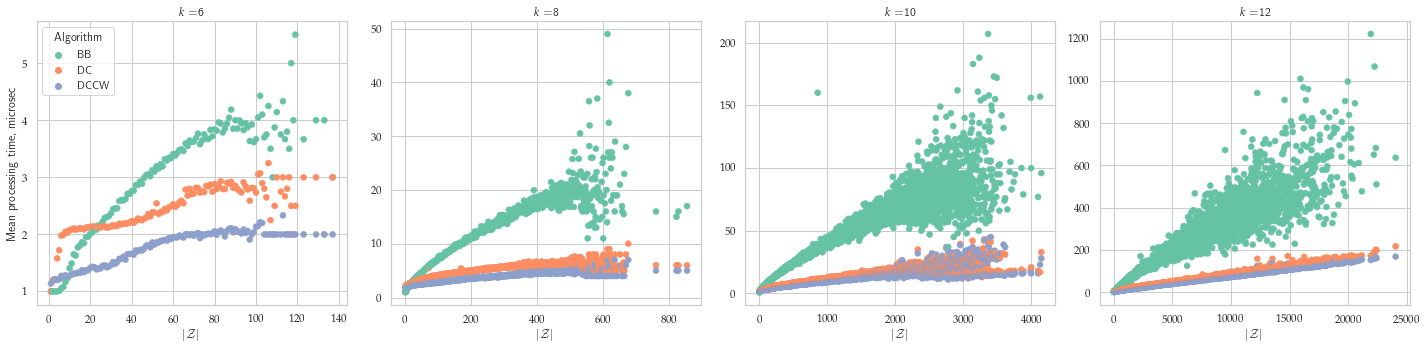

In [730]:
plot2_collection(random, False)

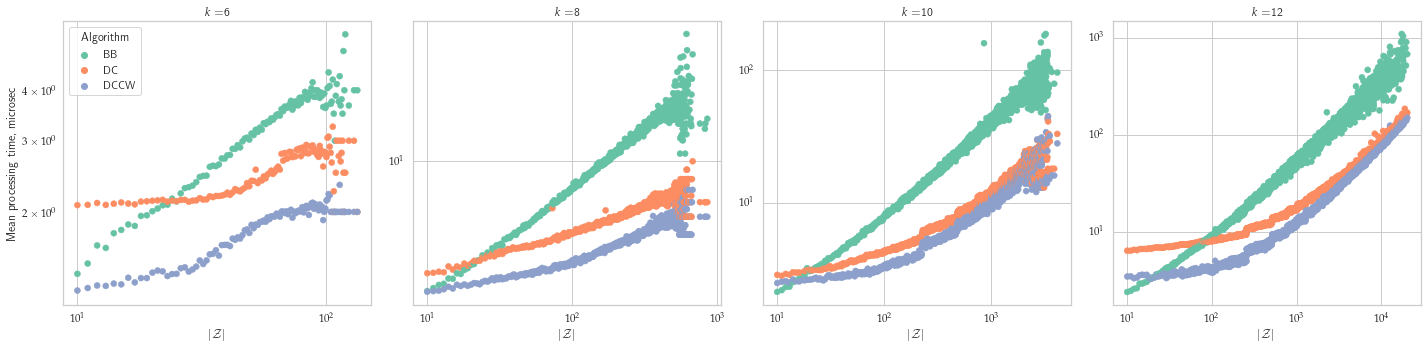

In [732]:
plot2_collection(random, True)

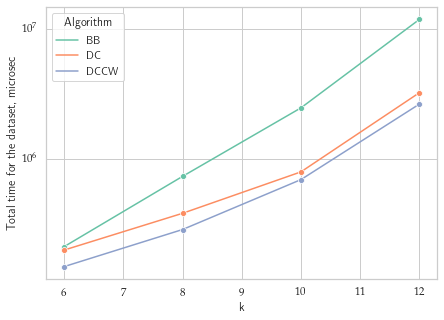

In [733]:
plot_total_time(random)

# Playground

## Ignore things below

## Worst-case of DC?

/home/nikolai/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


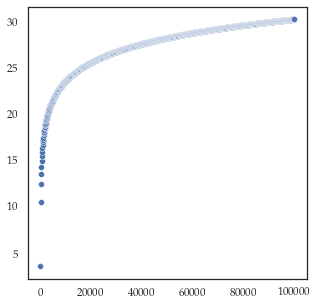

In [213]:
Z = 1024

def x(Z, k):
    res = 0
    for i in range(0, int(np.ceil(np.log2(k)))):
        res += 1/2 * np.log2(Z / 2**i)
        
    return res

xvalues = np.linspace(10, 100000, 1000)
yvalues = [x(v, k) for v in xvalues]
#yvalues

sns.scatterplot(xvalues, yvalues)

/home/nikolai/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


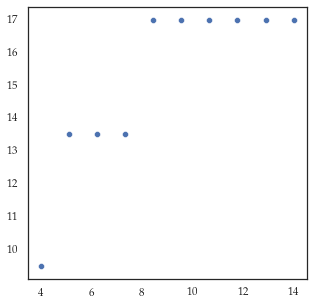

In [215]:
xvalues = np.linspace(4, 14, 10)
yvalues = [x(Z, v) for v in xvalues]
#yvalues

sns.scatterplot(xvalues, yvalues)

In [395]:
import numpy as np

log = True


min_x = 1
max_x = 10**6

c1 = 15
c2 = 15

def f1(x):
    #return 100 + c1 * x * np.log2(x)
    return 100 + c1 * x * np.log2(x)

def f2(x):
    return c2 * x

x = np.logspace(np.log10(min_x), np.log10(max_x), 100) if log else np.linspace(min_x, max_x, 100)

y1 = [f1(v) + 1 for v in x]
y2 = [f2(v) + 1 for v in x]

df = pd.DataFrame({'x': x, 'NlogN': y1, 'N': y2})
df = pd.melt(df, id_vars=['x'], value_vars=['NlogN', 'N'], var_name='alg', value_name='time')
df

x    alg          time
0          1.000000  NlogN  1.010000e+02
1          1.149757  NlogN  1.044722e+02
2          1.321941  NlogN  1.089844e+02
3          1.519911  NlogN  1.147701e+02
4          1.747528  NlogN  1.221097e+02
..              ...    ...           ...
195   572236.765935      N  8.583552e+06
196   657933.224658      N  9.868999e+06
197   756463.327555      N  1.134695e+07
198   869749.002618      N  1.304624e+07
199  1000000.000000      N  1.500000e+07

[200 rows x 3 columns]

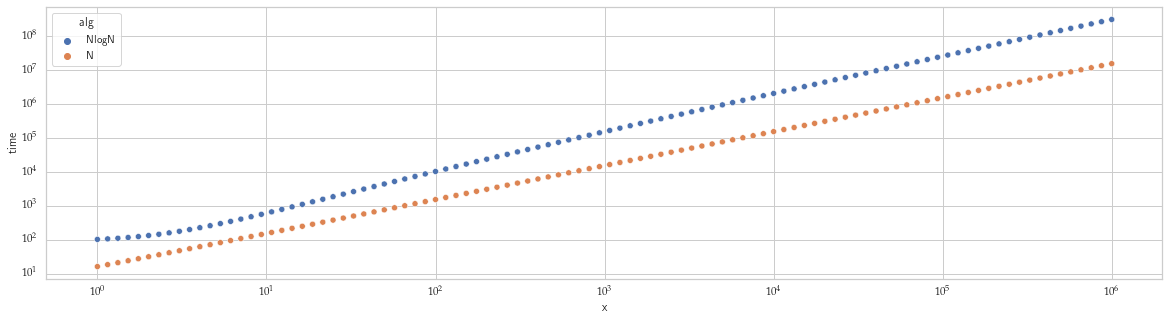

In [396]:
g = sns.scatterplot(data=df, x="x", y="time", hue="alg")
if log:
    g.set_yscale("log")
    g.set_xscale("log")

In [212]:
red = "#e7314b"
cyan = "#4bC2BC"
yellow = "#F2C400"
green = "#56B067"
blue = "#3395CD"
violet = "#8C5B9C"
dark_blue = "#31485f"
white = "#ffffff"

In [253]:
df = pd.read_csv("results/stats.csv")
df["time"] += 1
df["num_kmers"] += 1

In [264]:
dfx = df[df["k"] == 13]
dfx = dfx[dfx["omega"] == 1.5]
dfx.head()

alg  num_kmers   time   k  omega
16500      bb       4163    876  13    1.5
16501      dc       4163    953  13    1.5
16502  rappas       4163  37477  13    1.5
16503      bb       1744    570  13    1.5
16504      dc       1744    899  13    1.5

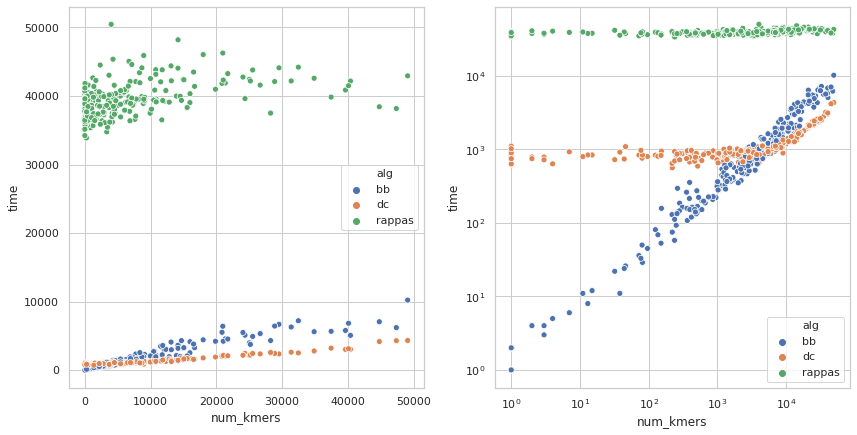

In [265]:
fig, axs = plt.subplots(ncols=2)
g1 = sns.scatterplot(x="num_kmers", y="time", hue="alg", data=dfx, ax=axs[0])
g2 = sns.scatterplot(x="num_kmers", y="time", hue="alg", data=dfx, ax=axs[1])
g2.set_yscale("log")
g2.set_xscale("log")

In [269]:
df = pd.read_csv("results/neotrop-random-10.csv")
df["time"] += 1
df["num_kmers"] += 1

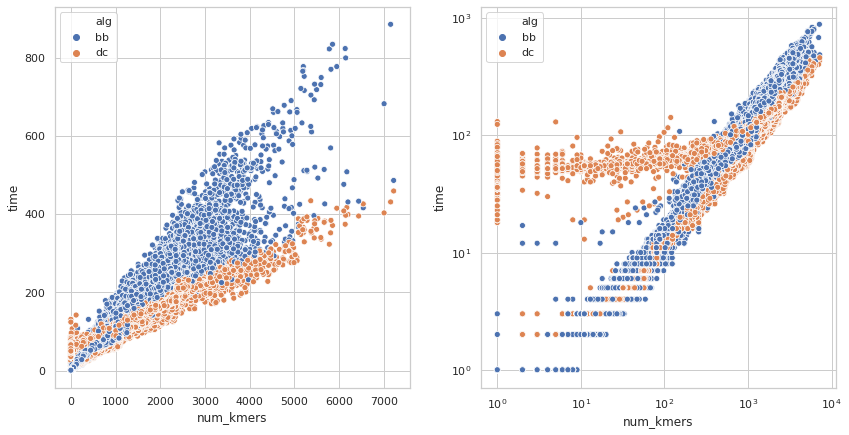

In [270]:
dfx = df[df["k"] == 10]
dfx = dfx[dfx["omega"] == 1.5]
dfx.head()

fig, axs = plt.subplots(ncols=2)
g1 = sns.scatterplot(x="num_kmers", y="time", hue="alg", data=dfx, ax=axs[0])
g2 = sns.scatterplot(x="num_kmers", y="time", hue="alg", data=dfx, ax=axs[1])
g2.set_yscale("log")
g2.set_xscale("log")

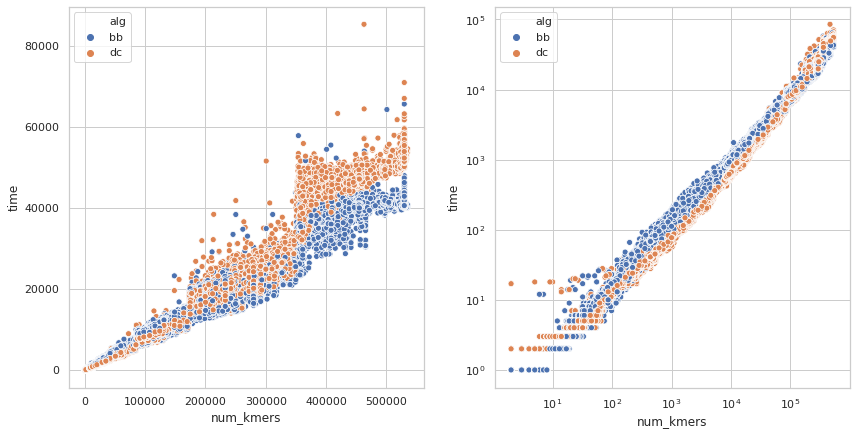

In [271]:
dfx = df[df["k"] == 10]
dfx = dfx[dfx["omega"] == 1.0]
dfx.head()

fig, axs = plt.subplots(ncols=2)
g1 = sns.scatterplot(x="num_kmers", y="time", hue="alg", data=dfx, ax=axs[0])
g2 = sns.scatterplot(x="num_kmers", y="time", hue="alg", data=dfx, ax=axs[1])
g2.set_yscale("log")
g2.set_xscale("log")

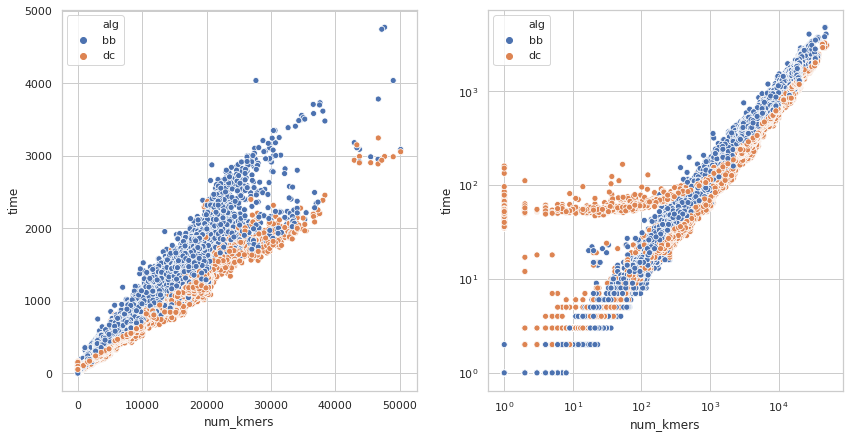

In [272]:
dfx = df[df["k"] == 10]
dfx = dfx[dfx["omega"] == 1.25]
dfx.head()

fig, axs = plt.subplots(ncols=2)
g1 = sns.scatterplot(x="num_kmers", y="time", hue="alg", data=dfx, ax=axs[0])
g2 = sns.scatterplot(x="num_kmers", y="time", hue="alg", data=dfx, ax=axs[1])
g2.set_yscale("log")
g2.set_xscale("log")

In [334]:
df = pd.read_csv("results/stats.csv")
df["time"] += 1
df["num_kmers"] += 1

In [333]:
df = pd.read_csv("results/neotrop-random-10.csv")
df["time"] += 1
df["num_kmers"] += 1

In [325]:
import math
def f(omega, k_values):
    for k in k_values:
        dfz = df.copy()
        dfz = dfz[dfz["alg"] == "bb"]
        dfz = dfz[dfz["omega"] == omega]
        dfz = dfz[dfz["k"] == k]

        print("TH\t#kmers\tratio")
        xx = dfz.num_kmers
        y = []
        for x in xx:
            #th = (omega / 4.0) ** k
            y.append(x / (4.0**k))

        dy = np.array(y)
        plt.hist(dy)
        plt.title(f"k = {k}, omega={omega}")

TH	#kmers	ratio


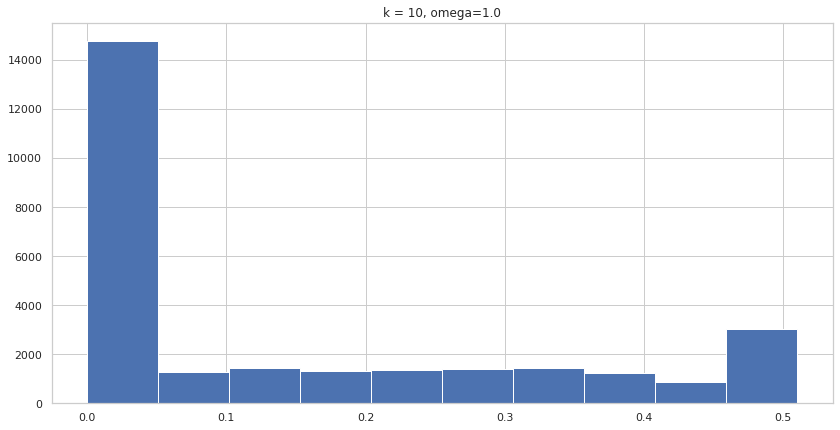

In [326]:
        
f(1.0, [10])

TH	#kmers	ratio


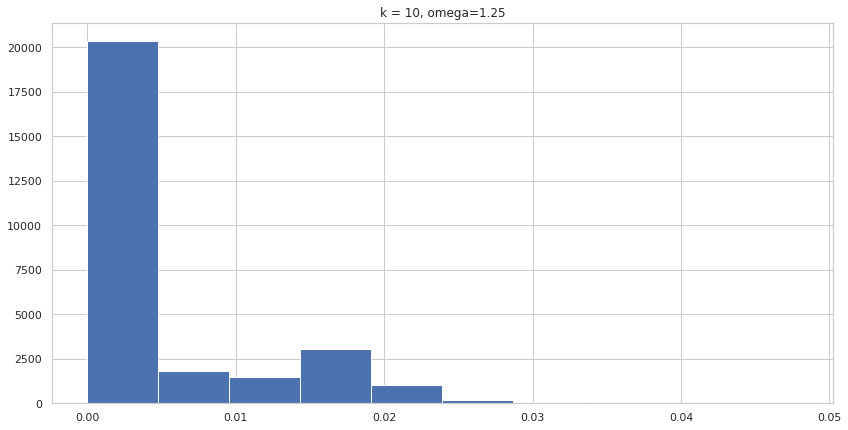

In [327]:
#f(1.25, [6, 7, 8, 9, 10, 11])
        
f(1.25, [10])

TH	#kmers	ratio


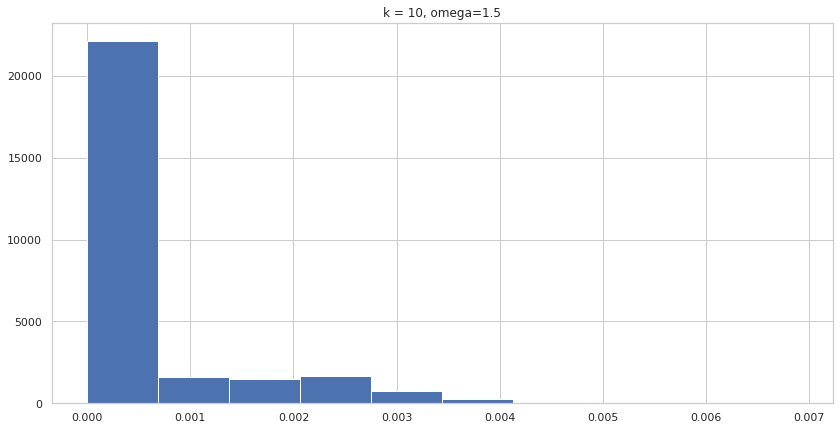

In [328]:
f(1.5, [10])

TH	#kmers	ratio
TH	#kmers	ratio


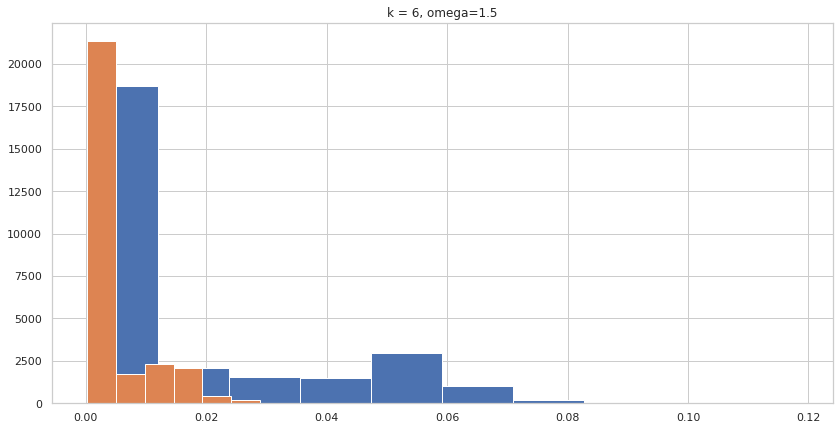

In [331]:
for omega in [1.25, 1.5]:        
    f(omega, [6])

TH	#kmers	ratio
TH	#kmers	ratio


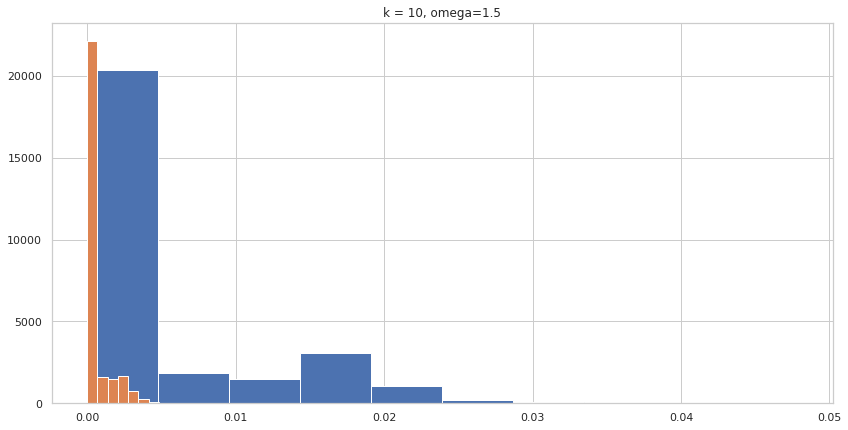

In [332]:
for omega in [1.25, 1.5]:        
    f(omega, [10])

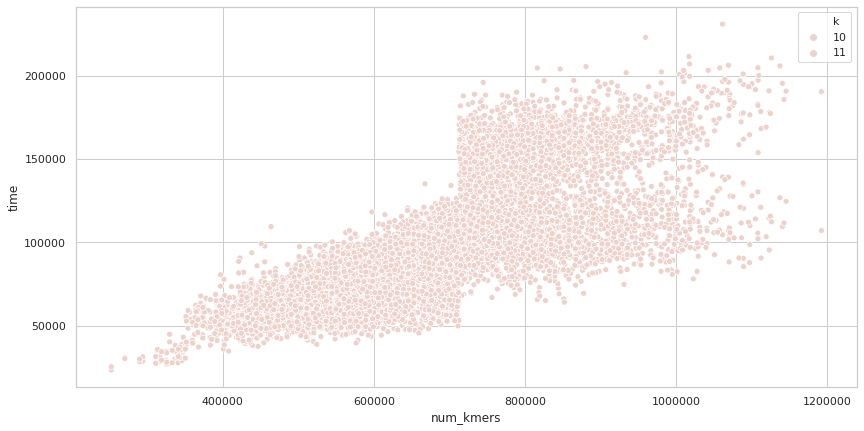

In [378]:
df = pd.read_csv("results/random.csv")
df["time"] += 1
df["num_kmers"] += 1
dfx = df.copy()
dfx = dfx[dfx["omega"]  == 1.0]
dfx = dfx[dfx["k"]  == 11]
sns.scatterplot(x="num_kmers", y="time", hue="k", data=dfx)

In [374]:
dfx[dfx["k"] == 12]

Empty DataFrame
Columns: [alg, num_kmers, time, k, omega]
Index: []

In [377]:
dfx.k.unique()

array([ 6,  7,  8,  9, 10, 11])

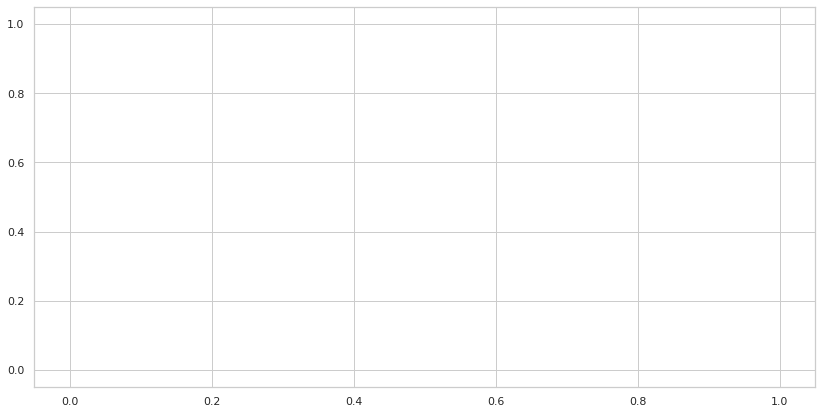

In [388]:
df = pd.read_csv("results/neotrop-random-10.csv")
df["time"] += 1
df["num_kmers"] += 1

k = 11
omega = 1.0

dfx = df.copy()
dfx = dfx[dfx["k"] == k]
dfx = dfx[dfx["omega"] == omega]

#plot(dfx, omega, f"Neotrop-10, omega={omega}", True)


sns.scatterplot(x="num_kmers", y="time", hue="alg", data=dfx)


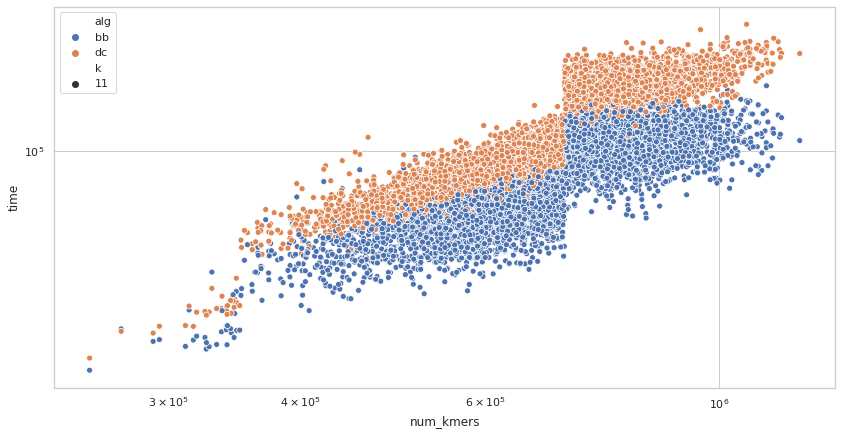

In [384]:
g2 = sns.scatterplot(x="num_kmers", y="time", hue="alg", data=dfx)
g2.set_yscale("log")
g2.set_xscale("log")

In [17]:
df = pd.read_csv("results/random.csv")
df["time"] += 1
df["num_kmers"] += 1

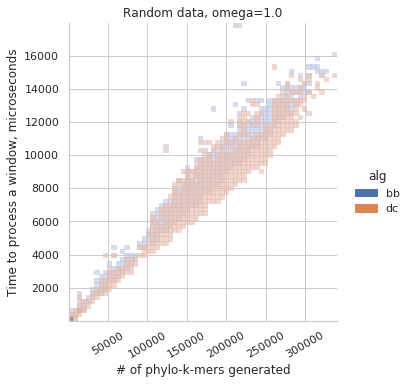

In [44]:
kde(df, 1.0, "Random data, omega=1.0")

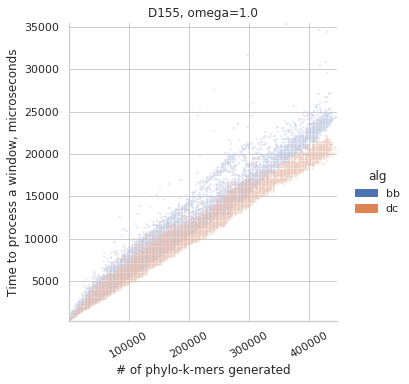

In [86]:
def kde_all(df, title, stylek=False):
    omega_values = df.omega.unique()
    ncols = 2
    nrows = int(len(omega_values) / 2)
    fig, axs = plt.subplots(len(omega_values))
    
    size = 6
    #fig.set_size_inches(len(omega_values)*size, size)
    fig.set_size_inches(size, len(omega_values)*size)
    
    for i, omega in enumerate(omega_values):
        dfx = df[df["omega"] == omega]
        g = sns.histplot(x="num_kmers", y="time", hue="alg", data=dfx, alpha=0.5, ax=axs[i])

        plt.title(title + f", omega={omega}")
        xlabel = "# of phylo-k-mers generated"
        ylabel = "Time to process a window, microseconds"
        g.set_xticklabels(g.get_xticklabels(), rotation=30)
        g.set_xlabel(xlabel)
        #g.set_ylabel(ylabel)

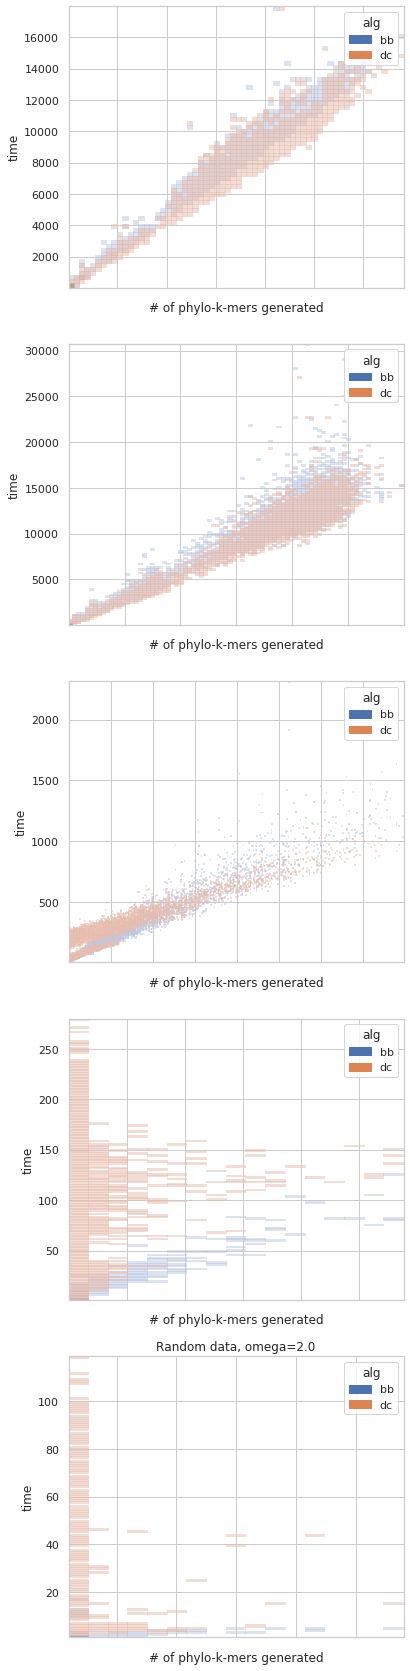

In [87]:
kde_all(df, "Random data")

In [115]:
df = pd.read_csv("results/dc-prefixes.csv")
df["time"] += 1
df["num_kmers"] += 1

In [109]:
#kde_all(df, "Random data, DC no join")

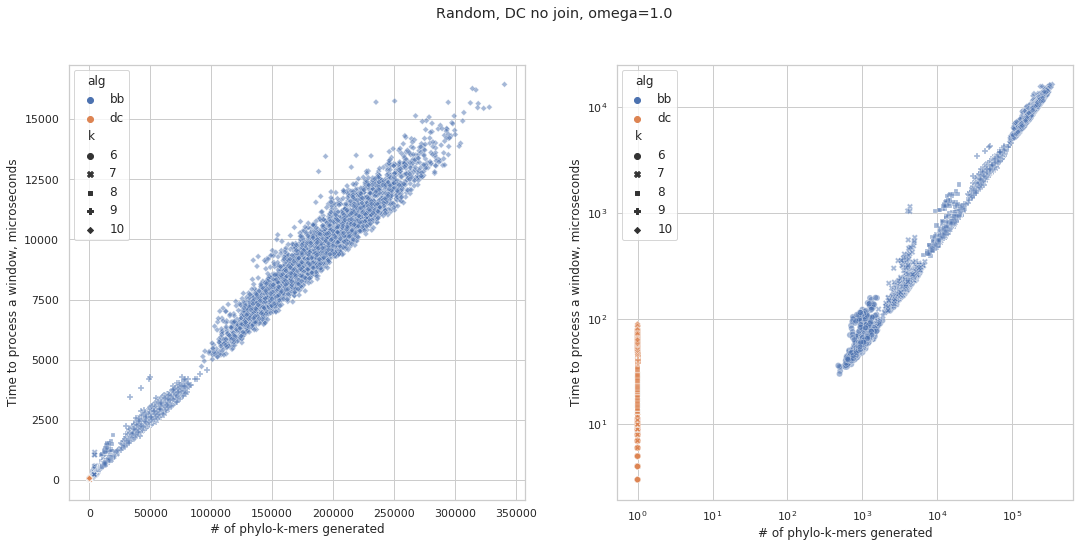

In [117]:
omega = 1.0
plot(df, omega, f"Random, DC no join, omega={omega}", True)

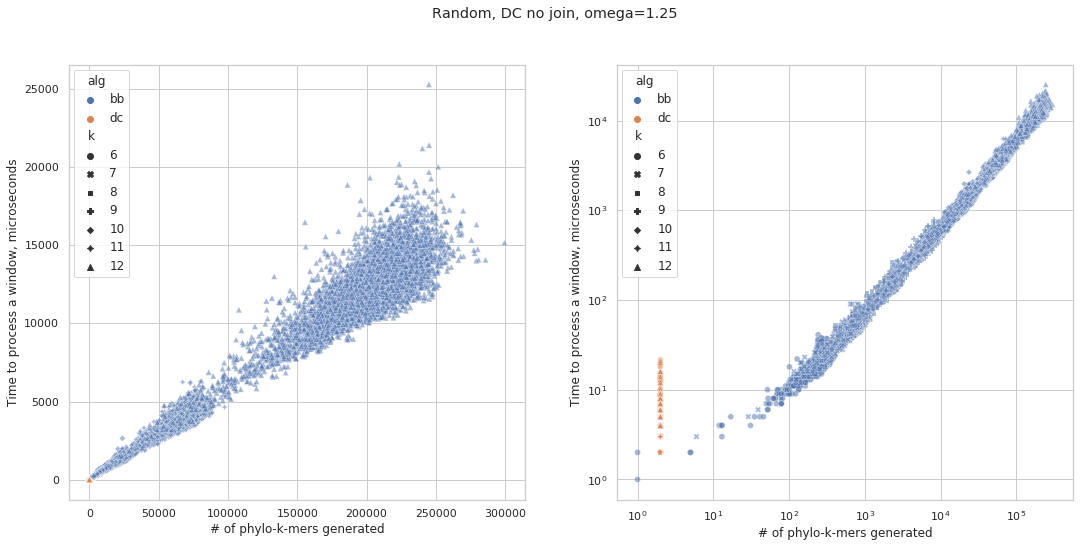

In [111]:
omega = 1.25
plot(df, omega, f"Random, DC no join, omega={omega}", True)

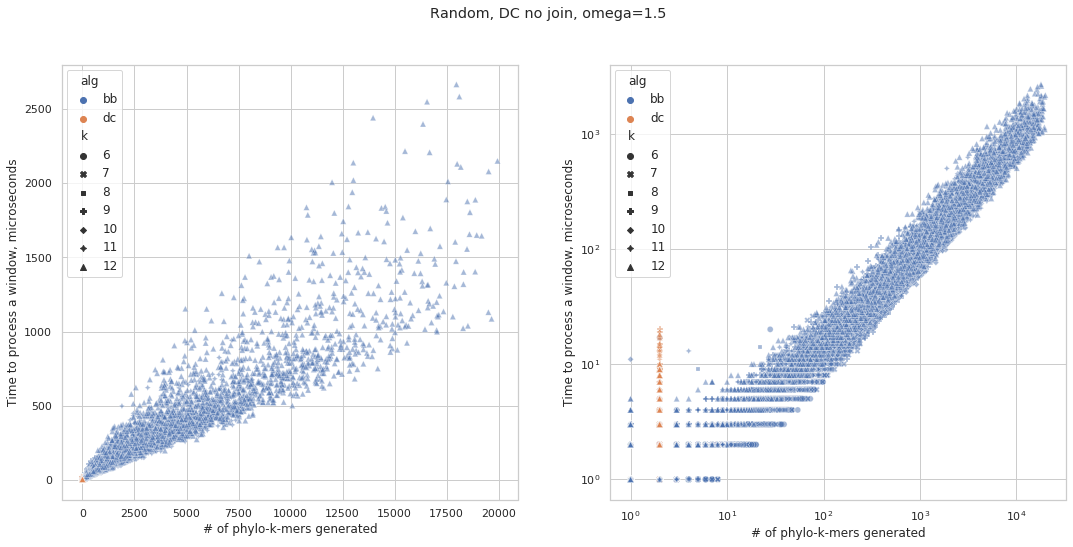

In [112]:
omega = 1.5
plot(df, omega, f"Random, DC no join, omega={omega}", True)

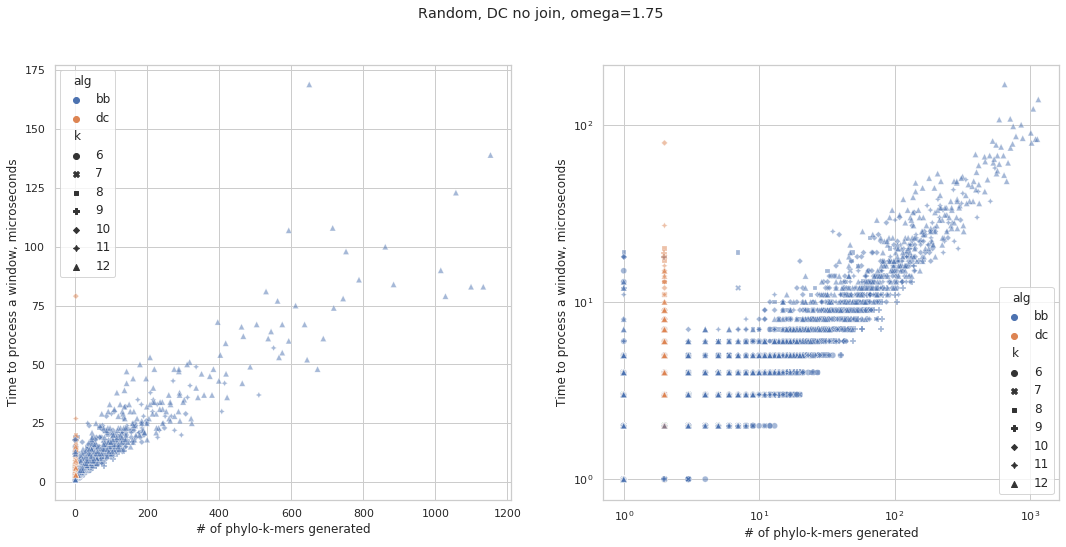

In [113]:
omega = 1.75
plot(df, omega, f"Random, DC no join, omega={omega}", True)

In [315]:
import tqdm

ks = []
o = []
gs = []
zs = []
ret_mean = []

with open('returns.txt') as f:
    for line in tqdm.tqdm(f.readlines(), position=0, leave=True):
        k, omega, stats = line.split(',')
        
        # all returns for that window
        z = [int(c) for c in stats[:-1]]
        
        # returns of good k-mers
        good = z.count(1)
        
        # the number of other returns between two good ones
        ret_stats = []
        count = 0
        for x in z:
            if x != 1:
                count += 1
            else:
                ret_stats.append(count)
                count = 0
                
        # average number of returns between two good k-mers
        ret_mean_value = np.array(ret_stats).mean()
        
        ks.append(int(k))
        o.append(float(omega))
        gs.append(good)
        zs.append(len(z))
        ret_mean.append(ret_mean_value)

100%|██████████| 116800/116800 [28:10<00:00, 69.11it/s]  


In [188]:
len(ks), len(o), len(gs), len(zs), len(ret_mean)

(16000, 16000, 16000, 16000, 16000)

In [287]:
df = pd.DataFrame(data={
    'k': ks, 'omega': o, 'good': gs, 'z': zs, 'ret_mean': ret_mean
})

In [288]:
# the ratio of good returns
df["ratio"] = df.good / df.z

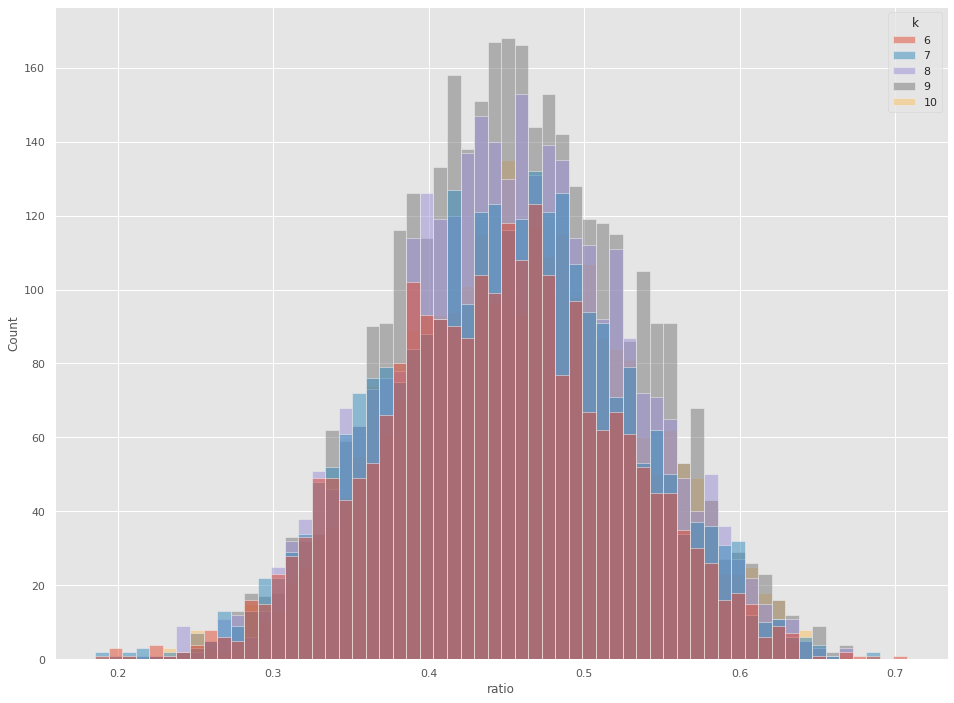

In [289]:
sns.histplot(data=df, x="ratio", hue="k")

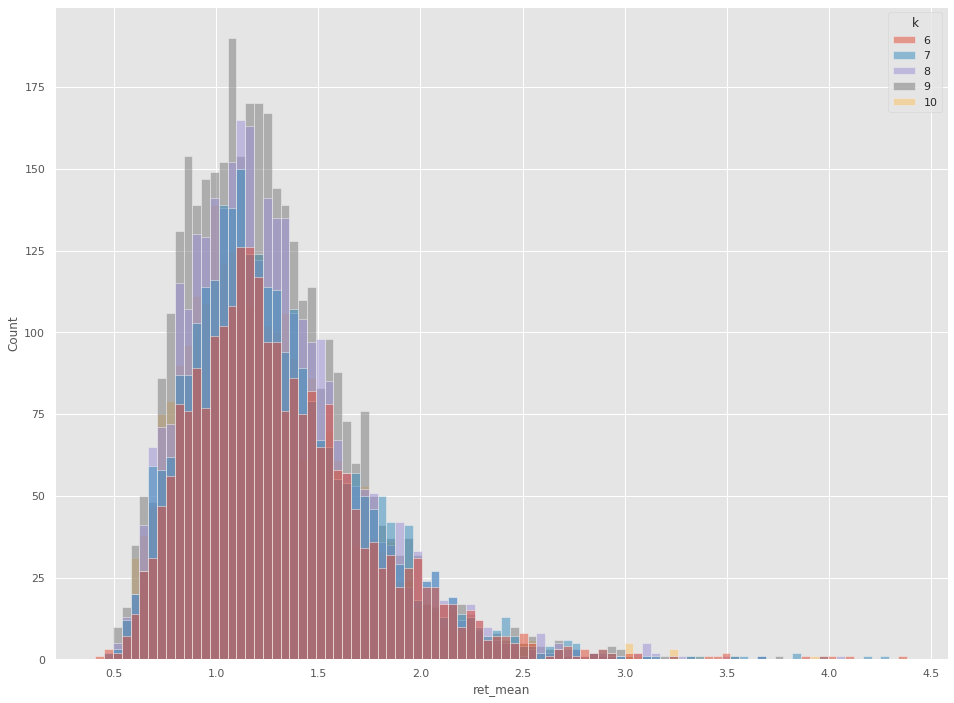

In [290]:
sns.histplot(data=df, x="ret_mean", hue="k")

In [293]:
df.k.unique()

array(['6', '7', '8', '9', '10'], dtype=object)

In [296]:
df10 = df[df["k"] == '10']
df10

k omega    good       z  ret_mean     ratio
12000  10     1  215000  548348  1.550381  0.392087
12001  10     1  198224  562620  1.838228  0.352323
12002  10     1  197084  403412  1.046818  0.488543
12003  10     1  211377  376880  0.782904  0.560860
12004  10     1  222999  417568  0.872443  0.534042
...    ..   ...     ...     ...       ...       ...
14623  10     1  238018  505344  1.123096  0.471002
14624  10     1  249326  495672  0.988012  0.503006
14625  10     1  266529  426140  0.598817  0.625449
14626  10     1  215480  617228  1.864391  0.349109
14627  10     1  217799  447612  1.055120  0.486580

[2628 rows x 6 columns]

In [297]:
data = df10["ret_mean"]
data

12000    1.550381
12001    1.838228
12002    1.046818
12003    0.782904
12004    0.872443
           ...   
14623    1.123096
14624    0.988012
14625    0.598817
14626    1.864391
14627    1.055120
Name: ret_mean, Length: 2628, dtype: float64

  1 / 98 : ksone
  2 / 98 : kstwobign
  3 / 98 : norm
  4 / 98 : alpha
  5 / 98 : anglit
  6 / 98 : arcsine
  7 / 98 : beta
  8 / 98 : betaprime
  9 / 98 : bradford
 10 / 98 : burr
 11 / 98 : burr12
 12 / 98 : fisk
 13 / 98 : cauchy
 14 / 98 : chi
 15 / 98 : chi2
 16 / 98 : cosine
 17 / 98 : dgamma
 18 / 98 : dweibull
 19 / 98 : expon
 20 / 98 : exponnorm
 21 / 98 : exponweib
 22 / 98 : exponpow
 23 / 98 : fatiguelife
 24 / 98 : foldcauchy
 25 / 98 : f
 26 / 98 : foldnorm
 27 / 98 : weibull_min
 28 / 98 : weibull_max
 29 / 98 : frechet_r
 30 / 98 : frechet_l
 31 / 98 : genlogistic
 32 / 98 : genpareto
 33 / 98 : genexpon
 34 / 98 : genextreme
 35 / 98 : gamma
 36 / 98 : erlang
 37 / 98 : gengamma
 38 / 98 : genhalflogistic
 39 / 98 : gompertz
 40 / 98 : gumbel_r
 41 / 98 : gumbel_l
 42 / 98 : halfcauchy
 43 / 98 : halflogistic
 44 / 98 : halfnorm
 45 / 98 : hypsecant
 46 / 98 : gausshyper
 47 / 98 : invgamma
 48 / 98 : invgauss
 49 / 98 : norminvgauss
 50 / 98 : invweibull
 51 / 98 : j

Text(0, 0.5, 'Frequency')

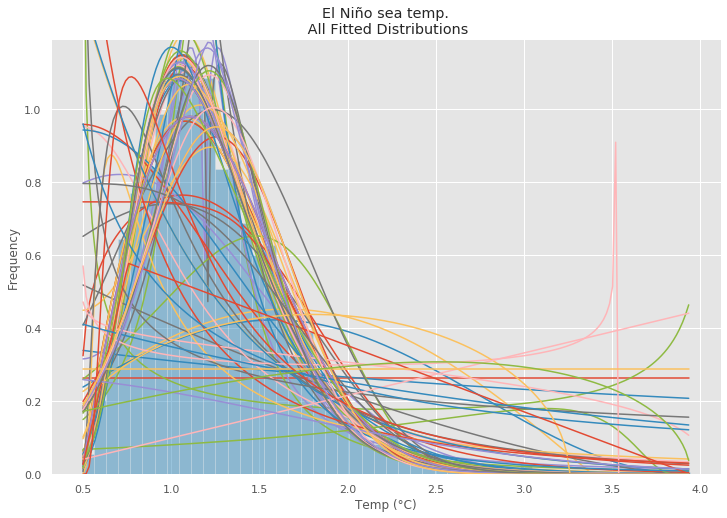

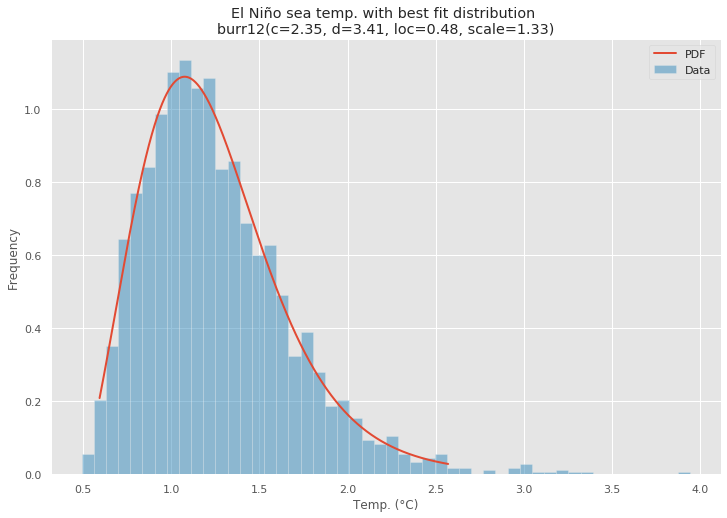

In [298]:
# https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass

    
    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
#data = pd.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())
#data = df.ret_mean

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 200, ax)
best_dist = best_distibutions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')

In [299]:
from distfit import distfit

dist = distfit()
dist.fit_transform(data)

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.6526712] [loc=1.255 scale=0.419]
[distfit] >[expon     ] [0.00 sec] [RSS: 4.7152257] [loc=0.491 scale=0.764]
[distfit] >[pareto    ] [0.04 sec] [RSS: 7.1949124] [loc=-0.408 scale=0.899]
[distfit] >[dweibull  ] [0.02 sec] [RSS: 0.5021895] [loc=1.208 scale=0.337]
[distfit] >[t         ] [0.05 sec] [RSS: 0.4560159] [loc=1.215 scale=0.347]
[distfit] >[genextreme] [0.06 sec] [RSS: 0.0745910] [loc=1.063 scale=0.320]
[distfit] >[gamma     ] [0.03 sec] [RSS: 0.0613680] [loc=0.446 scale=0.215]
[distfit] >[lognorm   ] [0.03 sec] [RSS: 0.0663738] [loc=0.180 scale=1.001]
[distfit] >[beta      ] [0.10 sec] [RSS: 0.0760168] [loc=0.295 scale=1217264301541.908]
[distfit] >[uniform   ] [0.00 sec] [RSS: 6.8543619] [loc=0.491 scale=3.453]
[distfit] >[loggamma  ] [0.08 sec] [RSS: 0.6990732] [loc=-131.761 scale=17.861]
[distfit] >Compute confidence interval [parametric]


{'model': {'distr': <scipy.stats._continuous_distns.gamma_gen at 0x7f8132c4e610>,
  'stats': 'RSS',
  'params': (3.769738040013445, 0.44631662011429285, 0.21460990087109522),
  'name': 'gamma',
  'model': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f7e5c8b5290>,
  'score': 0.06136797232532707,
  'loc': 0.44631662011429285,
  'scale': 0.21460990087109522,
  'arg': (3.769738040013445,),
  'CII_min_alpha': 0.7112104017990364,
  'CII_max_alpha': 2.03957829425845},
 'summary':          distr      score  LLE       loc        scale  \
 0        gamma   0.061368  NaN  0.446317      0.21461   
 1      lognorm  0.0663738  NaN  0.179765      1.00132   
 2   genextreme   0.074591  NaN   1.06339     0.320407   
 3         beta  0.0760168  NaN  0.294599  1.21726e+12   
 4            t   0.456016  NaN    1.2154     0.347122   
 5     dweibull    0.50219  NaN   1.20768     0.337356   
 6         norm   0.652671  NaN   1.25534     0.419024   
 7     loggamma   0.699073  NaN  -131.761      17.861

In [300]:
best_distr = dist.model
print(best_distr)

{'distr': <scipy.stats._continuous_distns.gamma_gen object at 0x7f8132c4e610>, 'stats': 'RSS', 'params': (3.769738040013445, 0.44631662011429285, 0.21460990087109522), 'name': 'gamma', 'model': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7e5c8b5290>, 'score': 0.06136797232532707, 'loc': 0.44631662011429285, 'scale': 0.21460990087109522, 'arg': (3.769738040013445,), 'CII_min_alpha': 0.7112104017990364, 'CII_max_alpha': 2.03957829425845}


In [301]:
dist.summary

distr      score  LLE       loc        scale  \
0        gamma   0.061368  NaN  0.446317      0.21461   
1      lognorm  0.0663738  NaN  0.179765      1.00132   
2   genextreme   0.074591  NaN   1.06339     0.320407   
3         beta  0.0760168  NaN  0.294599  1.21726e+12   
4            t   0.456016  NaN    1.2154     0.347122   
5     dweibull    0.50219  NaN   1.20768     0.337356   
6         norm   0.652671  NaN   1.25534     0.419024   
7     loggamma   0.699073  NaN  -131.761      17.8612   
8        expon    4.71523  NaN   0.49086     0.764479   
9      uniform    6.85436  NaN   0.49086      3.45337   
10      pareto    7.19491  NaN -0.408001     0.898861   

                                       arg  
0                     (3.769738040013445,)  
1                   (0.37908329687988596,)  
2                  (-0.02069092354797835,)  
3   (6.017043753879426, 7672052453396.461)  
4                     (6.471579286096512,)  
5                    (1.1814660489561954,)  
6                                       ()  
7                     (1715.507873205992,)  
8                                       ()  
9                                       ()  
10                   (1.5603767799308095,)

[distfit] >plot summary..


(<Figure size 1080x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7e5dc0d890>)

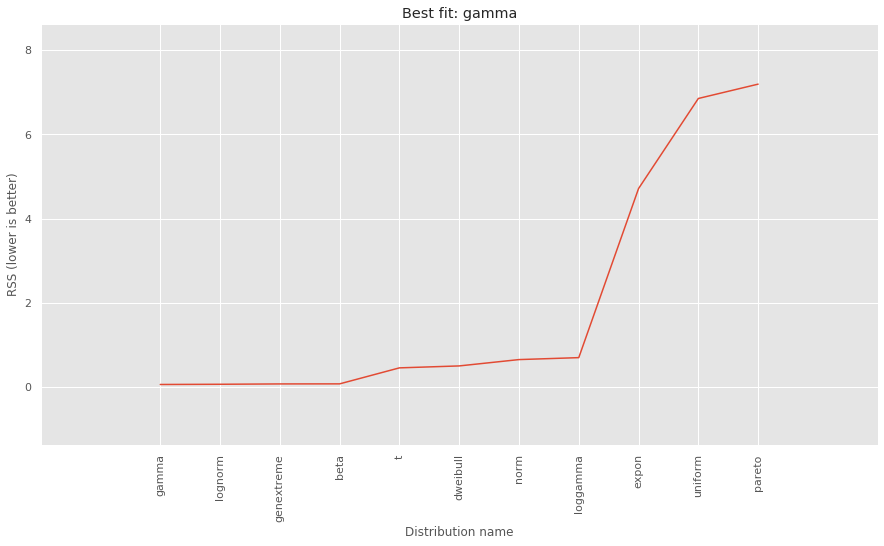

In [302]:
dist.plot_summary()

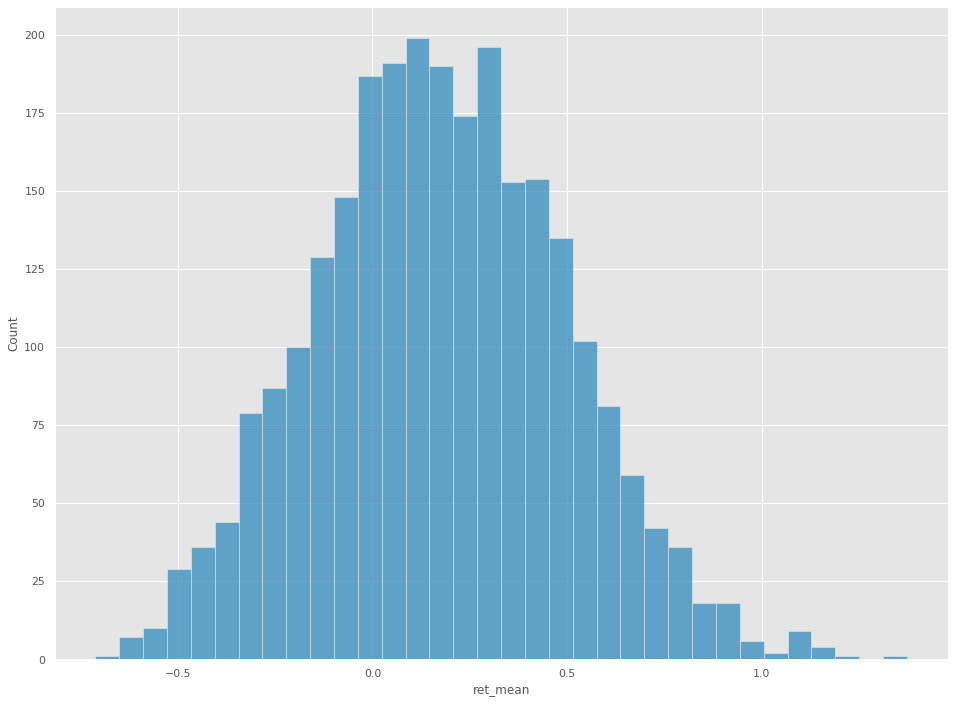

In [304]:
log_data = np.log(data)
sns.histplot(log_data)

In [305]:
st.shapiro(log_data)

(0.997759997844696, 0.0008257718291133642)

In [307]:
from scipy.stats import kstest

args = [best_distr["arg"], best_distr["loc"], best_distr["scale"]]
print(args)
kstest(data, 'gamma', args=args)

[(3.769738040013445,), 0.44631662011429285, 0.21460990087109522]


KstestResult(statistic=0.011788781267170895, pvalue=0.8584839413897786)

In [309]:
dist = distfit(distr="full")
dist.fit_transform(data)

[distfit] >fit..
[distfit] >transform..
[distfit] >[alpha          ] [0.04 sec] [RSS: 0.0768234] [loc=-0.889 scale=11.657]
[distfit] >[anglit         ] [0.01 sec] [RSS: 4.6565473] [loc=1.654 scale=2.209]
[distfit] >[arcsine        ] [0.05 sec] [RSS: 7.7280271] [loc=0.491 scale=3.581]
[distfit] >[beta           ] [0.10 sec] [RSS: 0.0760168] [loc=0.295 scale=1217264301541.908]
[distfit] >[betaprime      ] [0.13 sec] [RSS: 0.0622394] [loc=-0.120 scale=0.563]
[distfit] >[bradford       ] [0.03 sec] [RSS: 5.9134837] [loc=0.231 scale=3.714]
[distfit] >[burr           ] [0.20 sec] [RSS: 0.0719277] [loc=-30.960 scale=30.902]
[distfit] >[cauchy         ] [0.01 sec] [RSS: 0.9273871] [loc=1.160 scale=0.231]
[distfit] >[chi            ] [0.03 sec] [RSS: 0.1585249] [loc=0.488 scale=0.621]
[distfit] >[chi2           ] [0.03 sec] [RSS: 0.0613672] [loc=0.446 scale=0.107]
[distfit] >[cosine         ] [0.01 sec] [RSS: 4.5474322] [loc=1.583 scale=0.752]
[distfit] >[dgamma         ] [0.01 sec] [RSS: 0.401

{'model': {'distr': <scipy.stats._continuous_distns.powerlognorm_gen at 0x7f8132c26450>,
  'stats': 'RSS',
  'params': (15.5265864128279,
   0.971009240909407,
   0.4265095386448464,
   3.988259431186242),
  'name': 'powerlognorm',
  'model': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f7e5ccabdd0>,
  'score': 0.05847078985660577,
  'loc': 0.4265095386448464,
  'scale': 3.988259431186242,
  'arg': (15.5265864128279, 0.971009240909407),
  'CII_min_alpha': 0.7117398880175845,
  'CII_max_alpha': 2.0387585249867706},
 'summary':            distr        score  LLE       loc        scale  \
 0   powerlognorm    0.0584708  NaN   0.42651      3.98826   
 1              f    0.0609998  NaN  0.427351     0.815583   
 2           chi2    0.0613672  NaN  0.446318     0.107304   
 3          gamma     0.061368  NaN  0.446317      0.21461   
 4         erlang    0.0613684  NaN  0.446319      0.21461   
 ..           ...          ...  ...       ...          ...   
 75        pareto      7.1949

In [311]:
dist.model

{'distr': <scipy.stats._continuous_distns.powerlognorm_gen at 0x7f8132c26450>,
 'stats': 'RSS',
 'params': (15.5265864128279,
  0.971009240909407,
  0.4265095386448464,
  3.988259431186242),
 'name': 'powerlognorm',
 'model': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f7e5ccabdd0>,
 'score': 0.05847078985660577,
 'loc': 0.4265095386448464,
 'scale': 3.988259431186242,
 'arg': (15.5265864128279, 0.971009240909407),
 'CII_min_alpha': 0.7117398880175845,
 'CII_max_alpha': 2.0387585249867706}

In [314]:
args = [*dist.model["arg"], dist.model["loc"], dist.model["scale"]]
print(args)
kstest(data, 'powerlognorm', args=args)

[15.5265864128279, 0.971009240909407, 0.4265095386448464, 3.988259431186242]


KstestResult(statistic=0.0104774762470351, pvalue=0.9351612199486466)